# Problem 2: Sneaker vs Sandal Image Classification

In [146]:
import os
import numpy as np
import pandas as pd

import sklearn.linear_model
import sklearn.metrics
import sklearn.pipeline

from cross_validation import train_models_and_calc_scores_for_n_fold_cv
from performance_metrics_for_proba_predictions import calc_mean_binary_cross_entropy_from_probas

from tabulate import tabulate

In [147]:
# import plotting libraries
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn') # pretty matplotlib plots

import seaborn as sns
sns.set('notebook', style='whitegrid', font_scale=1.25)

In [148]:
SEED = 0
N_FOLDS_CV = 5
C_grid = np.logspace(-9, 6, 31)

In [149]:
DATA_DIR = 'data_sneaker_vs_sandal/'
x_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'x_train.csv'), delimiter=',', skiprows=1)
x_te_N = np.loadtxt(os.path.join(DATA_DIR, 'x_test.csv'), delimiter=',', skiprows=1)

M_shape = x_tr_M.shape
N_shape = x_te_N.shape

M = M_shape[0]
N = N_shape[0]

y_tr_M = np.loadtxt(os.path.join(DATA_DIR, 'y_train.csv'), delimiter=',', skiprows=1)

# here I will do the split 90% for training (cv) and 10% for testing
random_state = np.random.RandomState(int(SEED))
shuffled_row_ids = random_state.permutation(M)

percentage_training = 0.9
M_prime = int(M * percentage_training)

indices = np.random.permutation(x.shape[0])
training_idx, test_idx = shuffled_row_ids[:M_prime], shuffled_row_ids[M_prime:]
training_x_tr, test_x_tr = x_tr_M[training_idx,:], x_tr_M[test_idx,:]

training_y_tr, test_y_tr = y_tr_M[training_idx], y_tr_M[test_idx]

print(training_x_tr.shape, test_x_tr.shape)
print(training_y_tr.shape, test_y_tr.shape)

(10800, 784) (1200, 784)
(10800,) (1200,)


In [152]:
from tabulate import tabulate

positive_y_tr_M = np.count_nonzero(training_y_tr == 1)
positive_y_te_M = np.count_nonzero(test_y_tr == 1)

table = [['total number of examples', M_prime, M - M_prime],
        ['number of positive examples', positive_y_tr_M, positive_y_te_M],
        ['fraction of positive examples', np.around(positive_y_tr_M/M_prime, 3), np.around(positive_y_te_M/(M-M_prime), 3)]]

print(tabulate(table, headers=['', 'train', 'test']))

                                 train      test
-----------------------------  -------  --------
total number of examples       10800    1200
number of positive examples     5401     599
fraction of positive examples      0.5     0.499


## Method 0: Baseline
Baseline: raw pixel features, fed into a Logistic Regression classifier
- You should use sklearn.linear_model.LogisticRegression
- You should carefully justify all hyperparameters, and select at least one complexity hyperparameter via grid search

In [153]:
def make_poly_logistic_regr_pipeline(C=1):
    pipeline = sklearn.pipeline.Pipeline(
        steps=[
         #('rescaler', sklearn.preprocessing.MinMaxScaler()),
         #('poly_transformer', sklearn.preprocessing.PolynomialFeatures(degree=degree, include_bias=False)),
         ('linear_regr', sklearn.linear_model.LogisticRegression(C=C, solver='lbfgs', max_iter=1000)) #could use also penalty='l1' 
        ])
    # Return the constructed pipeline
    # We can treat it as if it has a 'regression' API
    # e.g. a fit and a predict method
    return pipeline

In [154]:
def c_grid_search_logistic_regr(xs):
    #C_grid = np.logspace(-9, 6, 31)

    # Store binary cross entropy (bce) for all C in C_grid;
    # So we can compare and select the best C in the future steps.
    tr_bce_list = list()
    va_bce_list = list()
    #te_bce_list = list()

    # Store the error rate: Fraction of examples that are mis-classified (using threshold=0.5)
    # (We visualize it later, but don't use it in the report).
    # Remember, we justified using BCE for training our classifier by saying
    # it provides an *upper bound* on the error rate.
    tr_err_list = list()
    va_err_list = list()
    #te_err_list = list()

    for C in C_grid:
        pipeline = make_poly_logistic_regr_pipeline(C)
       
        
        tr_error, valid_error, tr_bce, valid_bce = train_models_and_calc_scores_for_n_fold_cv(pipeline, xs, training_y_tr, N_FOLDS_CV, SEED)

        # print('C = ', C)
        # print('---tr_error---', tr_error)
        # print('---valid_error---', valid_error)
        # print('---tr_bce---', tr_bce)
        # print('---valid_bce---', valid_bce)

        # print('------------------------------------')


        err_tr = np.mean(tr_error)
        err_va = np.mean(valid_error)

        bce_tr = np.mean(tr_bce)
        bce_va = np.mean(valid_bce)

        # print('---err_tr---', err_tr)
        # print('---err_va---', err_va)
        # print('---bce_tr---', bce_tr)
        # print('---bce_va---', bce_va)

        # print('>>>>>>>>>>>>>>>>>><<<<<<<<<<<<<<<<<<<')

        tr_err_list.append(err_tr) # Error rate for training set. 
        va_err_list.append(err_va) # Error rate for validation set.

        # Save bce for future selection on Models.
        tr_bce_list.append(bce_tr) 
        va_bce_list.append(bce_va)
        
    return tr_err_list, va_err_list, tr_bce_list, va_bce_list



In [155]:
def plot_errors(tr_err_list, va_err_list, tr_bce_list, va_bce_list):
    plt.plot(np.log10(C_grid), tr_bce_list, 'b.-', label='train binary cross entropy')
    plt.plot(np.log10(C_grid), va_bce_list, 'r.-', label='valid binary cross entropy')

    plt.plot(np.log10(C_grid), tr_err_list, 'b:', label='train err')
    plt.plot(np.log10(C_grid), va_err_list, 'r:', label='valid err')

    plt.ylabel('error')
    plt.xlabel("log_{10} C");
    plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
    plt.ylim([0, 0.7]);

I am selecting the hyperparameter C via grid search. I used these valuse for C: C_grid = np.logspace(-9, 6, 31). now I will choose the model with the smallest cross entropy loss on the validation set.

In [156]:
def best_c(va_bce_list):
    # TODO Find the best C with the smallest cross entropy loss on the validation set
    idx_best_C = np.argmin(va_bce_list)
    #print(idx_best_C__lrF2)
    best_C_lr= C_grid[idx_best_C]

    print("Best C value for lr model:", best_C_lr)
    print("Best log_10(C) value for lr model:", np.log10(best_C_lr))
    
    return best_C_lr

In [157]:

# let's see out of curiosity which model minimizes the validation error rate

# TODO Find the best C with the smallest cross entropy loss on the validation set
idx_best_C_err_valid_rate = np.argmin(va_err_list)
#print(idx_best_C__lrF2)
best_C_lr_err_valid_rate= C_grid[idx_best_C_err_valid_rate]

print("Best C value for lr model:", best_C_lr_err_valid_rate)
print("Best log_10(C) value for lr model:", np.log10(best_C_lr_err_valid_rate))

Best C value for lr model: 1000.0
Best log_10(C) value for lr model: 3.0


In [158]:
# I am avoiding overfitting since I am choosing the model that minimizes the validation error not the training error.
# I am also doing CV, which does not overestimate the error rate as it happens in the validation set approach.

In [177]:
# retrieving the model with the best C for model 0
def best_c_model_error(best_C_lr, xs, xs_testing):
    best_C_model_0 = sklearn.linear_model.LogisticRegression(C=best_C_lr, solver='lbfgs', max_iter=1000)
    best_C_model_0.fit(xs, training_y_tr)


    yhat_tr = best_C_model_0.predict_proba(xs)[:,1]
    yhat_te = best_C_model_0.predict_proba(xs_testing)[:,1]


    #print("train error rate model 0 =", sklearn.metrics.zero_one_loss(y_tr_M, yhat_tr >= 0.5))
    tr_error_rate = sklearn.metrics.zero_one_loss(training_y_tr, yhat_tr >= 0.5)
    te_error_rate = sklearn.metrics.zero_one_loss(test_y_tr, yhat_te >= 0.5)
    #print("train bce model 0 =", calc_mean_binary_cross_entropy_from_probas(y_tr_M, yhat_tr))
    tr_bce = calc_mean_binary_cross_entropy_from_probas(training_y_tr, yhat_tr)
    te_bce = calc_mean_binary_cross_entropy_from_probas(test_y_tr, yhat_te)
    return best_C_model_0, tr_error_rate, tr_bce, te_error_rate, te_bce

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
Best C value for lr model (MODEL 0 - Baseline): 0.31622776601683794
Training error rate 0.4790416666666667
Validation error rate 0.48291666666666666
Training BCE 0.9999797450359569
Validation BCE 1.0000549643386765
train error rate model 0 (all training set)= 0.029916666666666702
train bce model 0 (all training set)= 0.12866163041996062
                                         model 0
-------------------------------------  ---------
best C                                 0.316228
CV training error rate                 0.479042
CV validation error rate               0.482917
CV Training BCE                        0.99998
CV Validation BCE                      1.00005
train error rate (whole training set)  0.0299167
train bce (whole training set)         0.128662


/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


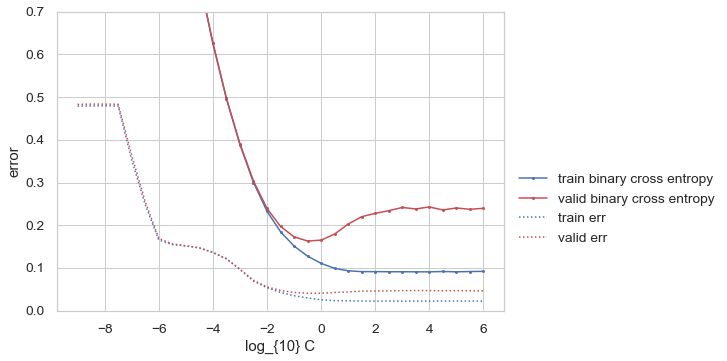

In [92]:
tr_err_list, va_err_list, tr_bce_list, va_bce_list = c_grid_search_logistic_regr(training_x_tr)

#print(C_grid.shape)
#print(tr_bce_list.shape)

plot_errors(tr_err_list, va_err_list, tr_bce_list, va_bce_list)

best_C_lr = best_c(va_bce_list)

best_C_model_0, tr_error_rate, tr_bce, te_error_rate, te_bce = best_c_model_error(best_C_lr, training_x_tr)

print("Best C value for lr model (MODEL 0 - Baseline):", best_C_lr)
print("Training error rate", tr_err_list[idx_best_C_err_valid_rate])
print("Validation error rate", va_err_list[idx_best_C_err_valid_rate])
print("Training BCE", tr_bce_list[idx_best_C_err_valid_rate])
print("Validation BCE", va_bce_list[idx_best_C_err_valid_rate])

print("train error rate model 0 (all training set)=", sklearn.metrics.zero_one_loss(training_y_tr, yhat_tr >= 0.5))
print("train bce model 0 (all training set)=", calc_mean_binary_cross_entropy_from_probas(training_y_tr, yhat_tr))


table = [
    ['best C', best_C_lr],
    ['CV training error rate', tr_err_list[idx_best_C_err_valid_rate]],
    ['CV validation error rate', va_err_list[idx_best_C_err_valid_rate]],
    ['CV Training BCE', tr_bce_list[idx_best_C_err_valid_rate]],
    ['CV Validation BCE', va_bce_list[idx_best_C_err_valid_rate]],
    ['train error rate (whole training set)', sklearn.metrics.zero_one_loss(training_y_tr, yhat_tr >= 0.5)],
    ['train bce (whole training set)', calc_mean_binary_cross_entropy_from_probas(training_y_tr, yhat_tr)]
]

print(tabulate(table, headers=['', 'model 0']))

Note that when I compute the training error rate and training bce on the whole training data, these error rates are slightly higher than when doing CV. This is due the variance of the validation set approach.

# Method 1:

In [160]:
# in order to find a nice transform function, I will look up which pixels had the most impact on the predictions.

#print(best_C_model_0.coef_)

coeff_28x28 = best_C_model_0.coef_.reshape((28, 28))

plt.imshow(coeff_28x28, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

#plt.xlabel("iterations");
#plt.ylabel('log loss')

#plt.legend(bbox_to_anchor=(1.5, 0.5)) # make legend outside plot
#plt.legend()
plt.colorbar()
plt.title('Learned Weight coefficients corresponding to the pixels of the original images')

ValueError: cannot reshape array of size 785 into shape (28,28)

In [179]:
def compute_results_model_on(xs, xs_testing, s):
    tr_err_list, va_err_list, tr_bce_list, va_bce_list = c_grid_search_logistic_regr(xs)

    #print(C_grid.shape)
    #print(tr_bce_list.shape)

    plot_errors(tr_err_list, va_err_list, tr_bce_list, va_bce_list)

    best_C_lr = best_c(va_bce_list)

    best_C_model_0, tr_error_rate, tr_bce, te_error_rate, te_bce = best_c_model_error(best_C_lr, xs, xs_testing)

    #print("Best C value for lr model (MODEL 0 - Baseline):", best_C_lr)
    #print("Training error rate", tr_err_list[idx_best_C_err_valid_rate])
    #print("Validation error rate", va_err_list[idx_best_C_err_valid_rate])
    #print("Training BCE", tr_bce_list[idx_best_C_err_valid_rate])
    #print("Validation BCE", va_bce_list[idx_best_C_err_valid_rate])

    #print("train error rate model 0 (all training set)=", sklearn.metrics.zero_one_loss(y_tr_M, yhat_tr >= 0.5))
    #print("train bce model 0 (all training set)=", calc_mean_binary_cross_entropy_from_probas(y_tr_M, yhat_tr))


    table = [
        ['best C', best_C_lr],
        ['CV training error rate', tr_err_list[idx_best_C_err_valid_rate]],
        ['CV validation error rate', va_err_list[idx_best_C_err_valid_rate]],
        ['CV Training BCE', tr_bce_list[idx_best_C_err_valid_rate]],
        ['CV Validation BCE', va_bce_list[idx_best_C_err_valid_rate]],
        ['train error rate (whole training set)', tr_error_rate],
        ['train bce (whole training set)', tr_bce],
        ['test error rate', te_error_rate],
        ['test bce', te_bce]
    ]

    print(tabulate(table, headers=['', 'model ' + s]))

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
                                         model baseline model (plain logistic regr)
-------------------------------------  --------------------------------------------
best C                                                                    0.316228
CV training error rate                                                    0.016713
CV validation error rate                                                  0.0557407
CV Training BCE                                                           0.0701276
CV Validation BCE                                                         0.441578
train error rate (whole training set)                                     0.0298148
train bce (whole training set)                                            0.129764
test error rate                                                           0.0341667
test bce                                                                  0.1

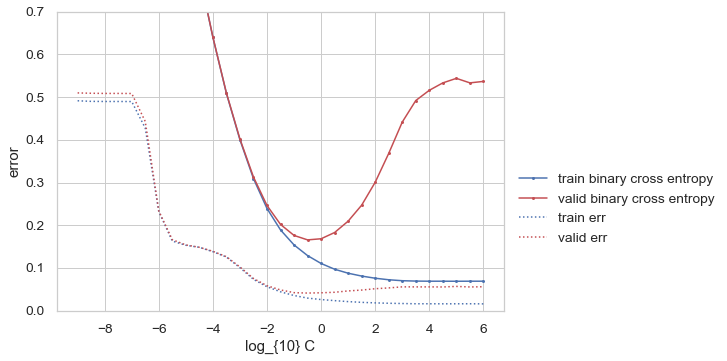

In [180]:
compute_results_model_on(training_x_tr, test_x_tr, "baseline model (plain logistic regr)")

(10800, 784)
(10800, 785)
[[0.         0.         0.         ... 0.         0.         0.15163018]
 [0.         0.         0.         ... 0.         0.         0.08345242]
 [0.         0.         0.         ... 0.         0.         0.26866742]
 ...
 [0.         0.         0.         ... 0.         0.         0.15335362]
 [0.         0.         0.         ... 0.         0.         0.10632329]
 [0.         0.         0.         ... 0.         0.         0.17113865]]


/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
                                         model average luminosity per pixel
-------------------------------------  ------------------------------------
best C                                                            0.316228
CV training error rate                                            0.0166435
CV validation error rate                                          0.0553704
CV Training BCE                                                   0.0700277
CV Validation BCE                                                 0.445426
train error rate (whole training set)                             0.0298148
train bce (whole training set)                                    0.129766
test error rate                                                   0.0341667
test bce                                                          0.144676


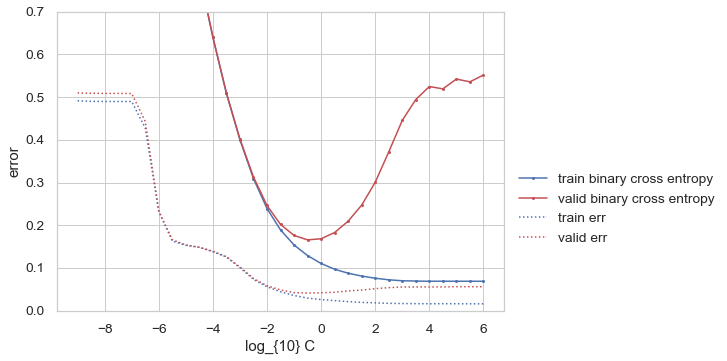

In [181]:
#sneakers shouldf be more beefy than sandals
# I expect that the number of pixels that are "on" (i.e. they are not 0.0) help distinguish sandals from sneakers
# I am going to create a new version of the x_tr_M, where each row will have an additional feature, the sum of the pixels that are "on". y_tr_M will remain the same




#print(np.asarray(sum_on_feature).shape)

sum_on_feature = [np.sum(x)/784 for x in training_x_tr] # 28*28 = 784
sum_on_feature = np.asarray(sum_on_feature)
sum_on_feature = sum_on_feature.reshape((sum_on_feature.shape[0], 1))
x_tr_M_sum_on = np.hstack((training_x_tr, sum_on_feature))

sum_on_feature_test = [np.sum(x)/784 for x in test_x_tr] # 28*28 = 784
sum_on_feature_test = np.asarray(sum_on_feature_test)
sum_on_feature_test = sum_on_feature_test.reshape((sum_on_feature_test.shape[0], 1))
x_te_M_sum_on = np.hstack((test_x_tr, sum_on_feature_test))

print(training_x_tr.shape)
print(x_tr_M_sum_on.shape)

print(x_tr_M_sum_on[0:200, :])

compute_results_model_on(x_tr_M_sum_on, x_te_M_sum_on, 'average luminosity per pixel')

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 1.0
Best log_10(C) value for lr model: 0.0
                                         model average number of "on" pixels per image
-------------------------------------  -----------------------------------------------
best C                                                                       1
CV training error rate                                                       0.010162
CV validation error rate                                                     0.0482407
CV Training BCE                                                              0.0480827
CV Validation BCE                                                            0.484065
train error rate (whole training set)                                        0.0251852
train bce (whole training set)                                               0.106304
test error rate                                                              0.0333333
test bce                                                               

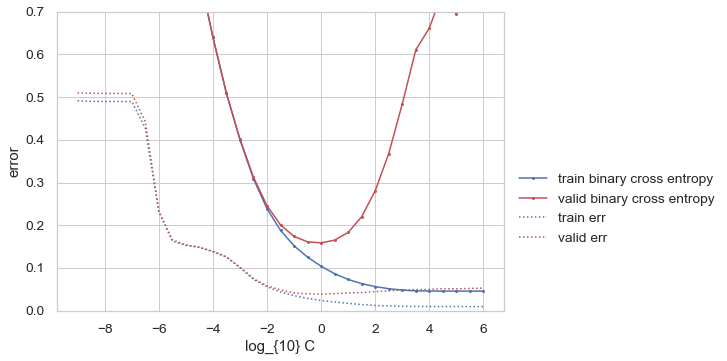

In [183]:
# now computing a new feature where I add 1 for each pixel that it is not 0, and averaging to the total number of pixels in the image, i.e. 28*28= 784



#print(np.asarray(avg_non_zero_feature).shape)
#print("feature before averaging", avg_non_zero_feature)
# training
avg_non_zero_feature = []
for x in training_x_tr:
    columns_not_zero = x > 0.0
    #print(np.sum(columns_not_zero))
    avg_non_zero_feature.append(np.sum(columns_not_zero))

avg_non_zero_feature = np.asarray(avg_non_zero_feature)
avg_non_zero_feature = avg_non_zero_feature/784
#print("feature after averaging", avg_non_zero_feature)
avg_non_zero_feature = avg_non_zero_feature.reshape((avg_non_zero_feature.shape[0], 1))
#print("feature after reshaping", avg_non_zero_feature)
x_tr_M_avg_non_zero = np.hstack((training_x_tr, avg_non_zero_feature))

# testing
avg_non_zero_feature_test = []
for x in test_x_tr:
    columns_not_zero_test = x > 0.0
    #print(np.sum(columns_not_zero))
    avg_non_zero_feature_test.append(np.sum(columns_not_zero_test))

avg_non_zero_feature_test = np.asarray(avg_non_zero_feature_test)
avg_non_zero_feature_test = avg_non_zero_feature_test/784
#print("feature after averaging", avg_non_zero_feature)
avg_non_zero_feature_test = avg_non_zero_feature_test.reshape((avg_non_zero_feature_test.shape[0], 1))
#print("feature after reshaping", avg_non_zero_feature)
x_te_M_avg_non_zero = np.hstack((test_x_tr, avg_non_zero_feature_test))

#print(training_x_tr.shape)
#print(x_tr_M_avg_non_zero.shape)

#print(x_tr_M_avg_non_zero[0:200, :])

compute_results_model_on(x_tr_M_avg_non_zero, x_te_M_avg_non_zero, 'average number of \"on\" pixels per image')

In [111]:
# testing hstack
arr1 = np.asarray([1, 2, 3, 4, 5, 6]).reshape((3, 2))
print(arr1)
arr2 = np.asarray([4, 8, 5]).reshape((3, 1))
print(arr1.shape)
print(arr2.shape)
print(np.hstack((arr1, arr2)))

[[1 2]
 [3 4]
 [5 6]]
(3, 2)
(3, 1)
[[1 2 4]
 [3 4 8]
 [5 6 5]]


/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
                                         model number of on pixels per image
-------------------------------------  -------------------------------------
best C                                                             0.316228
CV training error rate                                             0.0171296
CV validation error rate                                           0.0410185
CV Training BCE                                                    0.0713019
CV Validation BCE                                                  0.226692
train error rate (whole training set)                              0.0259259
train bce (whole training set)                                     0.110689
test error rate                                                    0.0341667
test bce                                                           0.142598


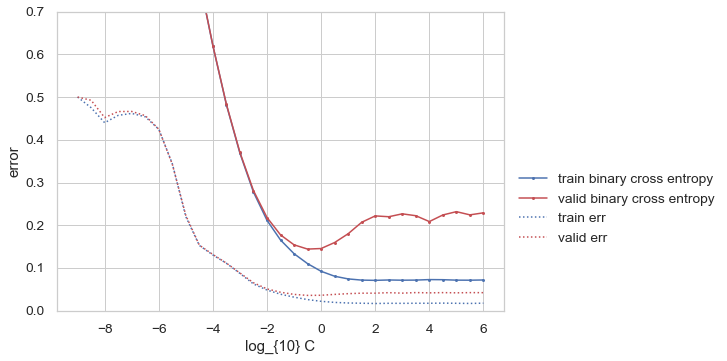

In [184]:
# now computing a new feature where I add 1 for each pixel that it is not 0, and WITHOUT averaging
#print(np.asarray(non_zero_feature).shape)

#training
non_zero_feature = list()
for x in training_x_tr:
    columns_not_zero = x > 0.0
    non_zero_feature.append(np.sum(columns_not_zero))

non_zero_feature = np.asarray(non_zero_feature)
non_zero_feature = non_zero_feature.reshape(non_zero_feature.shape[0], 1)
x_tr_M_non_zero = np.hstack((training_x_tr, non_zero_feature))

#testing

non_zero_feature_test = list()
for x in test_x_tr:
    columns_not_zero_test = x > 0.0
    non_zero_feature_test.append(np.sum(columns_not_zero_test))

non_zero_feature_test = np.asarray(non_zero_feature_test)
non_zero_feature_test = non_zero_feature_test.reshape(non_zero_feature_test.shape[0], 1)
x_te_M_non_zero = np.hstack((test_x_tr, non_zero_feature_test))

#print(training_x_tr.shape)
#print(x_tr_M_non_zero.shape)

#print(x_tr_M_non_zero[100:200, :])

compute_results_model_on(x_tr_M_non_zero, x_te_M_non_zero 'number of on pixels per image')

In [ ]:
# https://towardsdatascience.com/building-convolutional-neural-network-using-numpy-from-scratch-b30aac50e50a
# different filters : https://www.saama.com/different-kinds-convolutional-filters/

l1_filter = np.zeros((2,3,3))

l1_filter[0, :, :] = np.array([[[-1, 0, 1],
                                   [-1, 0, 1],
                                   [-1, 0, 1]]])
l1_filter[1, :, :] = np.array([[[1,   1,  1],
                                   [0,   0,  0],
                                   [-1, -1, -1]]])

def conv_(img, conv_filter):
    filter_size = conv_filter.shape[1]
    result = np.zeros((img.shape))
    #Looping through the image to apply the convolution operation.
    for r in np.uint16(np.arange(filter_size/2.0, 
                          img.shape[0]-filter_size/2.0+1)):
        for c in np.uint16(np.arange(filter_size/2.0, 
                                           img.shape[1]-filter_size/2.0+1)):
            """
            Getting the current region to get multiplied with the filter.
            How to loop through the image and get the region based on 
            the image and filer sizes is the most tricky part of convolution.
            """
            curr_region = img[r-np.uint16(np.floor(filter_size/2.0)):r+np.uint16(np.ceil(filter_size/2.0)), 
                              c-np.uint16(np.floor(filter_size/2.0)):c+np.uint16(np.ceil(filter_size/2.0))]
            #Element-wise multipliplication between the current region and the filter.
            curr_result = curr_region * conv_filter
            conv_sum = np.sum(curr_result) #Summing the result of multiplication.
            result[r, c] = conv_sum #Saving the summation in the convolution layer feature map.
            
    #Clipping the outliers of the result matrix.
    final_result = result[np.uint16(filter_size/2.0):result.shape[0]-np.uint16(filter_size/2.0), 
                          np.uint16(filter_size/2.0):result.shape[1]-np.uint16(filter_size/2.0)]
    return final_result

def conv(img, conv_filter):
    if len(img.shape) > 2 or len(conv_filter.shape) > 3: # Check if number of image channels matches the filter depth.
        if img.shape[-1] != conv_filter.shape[-1]:
            print("Error: Number of channels in both image and filter must match.")
            sys.exit()
    if conv_filter.shape[1] != conv_filter.shape[2]: # Check if filter dimensions are equal.
        print('Error: Filter must be a square matrix. I.e. number of rows and columns must match.')
        sys.exit()
    if conv_filter.shape[1]%2==0: # Check if filter diemnsions are odd.
        print('Error: Filter must have an odd size. I.e. number of rows and columns must be odd.')
        sys.exit()

    # An empty feature map to hold the output of convolving the filter(s) with the image.
    feature_maps = np.zeros((img.shape[0]-conv_filter.shape[1]+1, 
                                img.shape[1]-conv_filter.shape[1]+1, 
                                conv_filter.shape[0]))

    # Convolving the image by the filter(s).
    for filter_num in range(conv_filter.shape[0]):
        #print("Filter ", filter_num + 1)
        curr_filter = conv_filter[filter_num, :] # getting a filter from the bank.
        """ 
        Checking if there are mutliple channels for the single filter.
        If so, then each channel will convolve the image.
        The result of all convolutions are summed to return a single feature map.
        """
        if len(curr_filter.shape) > 2:
            conv_map = conv_(img[:, :, 0], curr_filter[:, :, 0]) # Array holding the sum of all feature maps.
            for ch_num in range(1, curr_filter.shape[-1]): # Convolving each channel with the image and summing the results.
                conv_map = conv_map + conv_(img[:, :, ch_num], 
                                  curr_filter[:, :, ch_num])
        else: # There is just a single channel in the filter.
            conv_map = conv_(img, curr_filter)
        feature_maps[:, :, filter_num] = conv_map # Holding feature map with the current filter.
    return feature_maps # Returning all feature maps.

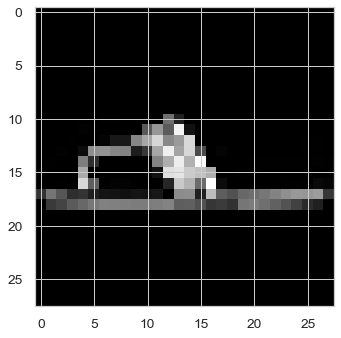

In [187]:

plt.imshow(training_x_tr[10].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray')



Filter  1
Filter  2
(26, 26)


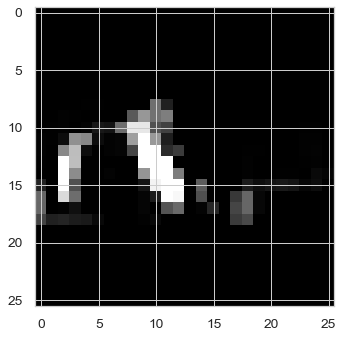

In [189]:
new_image = conv(training_x_tr[10].reshape(28,28), l1_filter)
print(new_image[:,:,0].shape)
plt.imshow(new_image[:,:,0], interpolation='nearest', vmin=0, vmax=1, cmap='gray')


Filter  1
Filter  2
(26, 26)
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
F

Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1
Filter  2
Filter  1


AttributeError: 'list' object has no attribute 'shape'

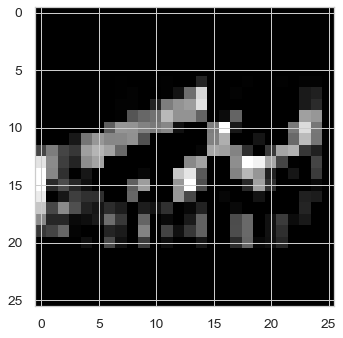

In [190]:
# Now I will create a new dataset with the convoluted images



new_image = conv(training_x_tr[0].reshape(28,28), l1_filter)
print(new_image[:,:,0].shape)
plt.imshow(new_image[:,:,0], interpolation='nearest', vmin=0, vmax=1, cmap='gray')


#training
convoluted_training_x_tr = list()
for x in training_x_tr:
    new_x = conv(x.reshape(28,28), l1_filter)
    flat_shape = new_x.shape[0]*new_x.shape[1]
    convoluted_training_x_tr.append(new_x[:,:,0].reshape((flat_shape, 1)))

#testing

convoluted_test_x_tr = list()
for x in test_x_tr:
    new_x = conv(x.reshape(28,28), l1_filter)
    flat_shape = new_x.shape[0]*new_x.shape[1]
    convoluted_test_x_tr.append(new_x[:,:,0].reshape((flat_shape, 1)))

compute_results_model_on(convoluted_training_x_tr, convoluted_test_x_tr, 'edge detection convolution model')


In [201]:
# Now I will create a new dataset with the convoluted images

#training
iter = 0
convoluted_training_x_tr = list()
for x in training_x_tr:
    print('training iter', iter)
    iter = iter + 1
    new_x = conv(x.reshape(28,28), l1_filter)
    flat_shape = new_x.shape[0]*new_x.shape[1]
    convoluted_training_x_tr.append(new_x[:,:,0].reshape((flat_shape)))

#testing
iter = 0
convoluted_test_x_tr = list()
for x in test_x_tr:
    print('test iter', iter)
    iter = iter + 1
    new_x = conv(x.reshape(28,28), l1_filter)
    flat_shape = new_x.shape[0]*new_x.shape[1]
    convoluted_test_x_tr.append(new_x[:,:,0].reshape((flat_shape)))

compute_results_model_on(convoluted_training_x_tr, convoluted_test_x_tr, 'edge detection convolution model')


training iter 0
Filter  1
Filter  2
training iter 1
Filter  1
Filter  2
training iter 2
Filter  1
Filter  2
training iter 3
Filter  1
Filter  2
training iter 4
Filter  1
Filter  2
training iter 5
Filter  1
Filter  2
training iter 6
Filter  1
Filter  2
training iter 7
Filter  1
Filter  2
training iter 8
Filter  1
Filter  2
training iter 9
Filter  1
Filter  2
training iter 10
Filter  1
Filter  2
training iter 11
Filter  1
Filter  2
training iter 12
Filter  1
Filter  2
training iter 13
Filter  1
Filter  2
training iter 14
Filter  1
Filter  2
training iter 15
Filter  1
Filter  2
training iter 16
Filter  1
Filter  2
training iter 17
Filter  1
Filter  2
training iter 18
Filter  1
Filter  2
training iter 19
Filter  1
Filter  2
training iter 20
Filter  1
Filter  2
training iter 21
Filter  1
Filter  2
training iter 22
Filter  1
Filter  2
training iter 23
Filter  1
Filter  2
training iter 24
Filter  1
Filter  2
training iter 25
Filter  1
Filter  2
training iter 26
Filter  1
Filter  2
training it

Filter  2
training iter 221
Filter  1
Filter  2
training iter 222
Filter  1
Filter  2
training iter 223
Filter  1
Filter  2
training iter 224
Filter  1
Filter  2
training iter 225
Filter  1
Filter  2
training iter 226
Filter  1
Filter  2
training iter 227
Filter  1
Filter  2
training iter 228
Filter  1
Filter  2
training iter 229
Filter  1
Filter  2
training iter 230
Filter  1
Filter  2
training iter 231
Filter  1
Filter  2
training iter 232
Filter  1
Filter  2
training iter 233
Filter  1
Filter  2
training iter 234
Filter  1
Filter  2
training iter 235
Filter  1
Filter  2
training iter 236
Filter  1
Filter  2
training iter 237
Filter  1
Filter  2
training iter 238
Filter  1
Filter  2
training iter 239
Filter  1
Filter  2
training iter 240
Filter  1
Filter  2
training iter 241
Filter  1
Filter  2
training iter 242
Filter  1
Filter  2
training iter 243
Filter  1
Filter  2
training iter 244
Filter  1
Filter  2
training iter 245
Filter  1
Filter  2
training iter 246
Filter  1
Filter  2
tr

Filter  2
training iter 447
Filter  1
Filter  2
training iter 448
Filter  1
Filter  2
training iter 449
Filter  1
Filter  2
training iter 450
Filter  1
Filter  2
training iter 451
Filter  1
Filter  2
training iter 452
Filter  1
Filter  2
training iter 453
Filter  1
Filter  2
training iter 454
Filter  1
Filter  2
training iter 455
Filter  1
Filter  2
training iter 456
Filter  1
Filter  2
training iter 457
Filter  1
Filter  2
training iter 458
Filter  1
Filter  2
training iter 459
Filter  1
Filter  2
training iter 460
Filter  1
Filter  2
training iter 461
Filter  1
Filter  2
training iter 462
Filter  1
Filter  2
training iter 463
Filter  1
Filter  2
training iter 464
Filter  1
Filter  2
training iter 465
Filter  1
Filter  2
training iter 466
Filter  1
Filter  2
training iter 467
Filter  1
Filter  2
training iter 468
Filter  1
Filter  2
training iter 469
Filter  1
Filter  2
training iter 470
Filter  1
Filter  2
training iter 471
Filter  1
Filter  2
training iter 472
Filter  1
Filter  2
tr

training iter 664
Filter  1
Filter  2
training iter 665
Filter  1
Filter  2
training iter 666
Filter  1
Filter  2
training iter 667
Filter  1
Filter  2
training iter 668
Filter  1
Filter  2
training iter 669
Filter  1
Filter  2
training iter 670
Filter  1
Filter  2
training iter 671
Filter  1
Filter  2
training iter 672
Filter  1
Filter  2
training iter 673
Filter  1
Filter  2
training iter 674
Filter  1
Filter  2
training iter 675
Filter  1
Filter  2
training iter 676
Filter  1
Filter  2
training iter 677
Filter  1
Filter  2
training iter 678
Filter  1
Filter  2
training iter 679
Filter  1
Filter  2
training iter 680
Filter  1
Filter  2
training iter 681
Filter  1
Filter  2
training iter 682
Filter  1
Filter  2
training iter 683
Filter  1
Filter  2
training iter 684
Filter  1
Filter  2
training iter 685
Filter  1
Filter  2
training iter 686
Filter  1
Filter  2
training iter 687
Filter  1
Filter  2
training iter 688
Filter  1
Filter  2
training iter 689
Filter  1
Filter  2
training ite

training iter 882
Filter  1
Filter  2
training iter 883
Filter  1
Filter  2
training iter 884
Filter  1
Filter  2
training iter 885
Filter  1
Filter  2
training iter 886
Filter  1
Filter  2
training iter 887
Filter  1
Filter  2
training iter 888
Filter  1
Filter  2
training iter 889
Filter  1
Filter  2
training iter 890
Filter  1
Filter  2
training iter 891
Filter  1
Filter  2
training iter 892
Filter  1
Filter  2
training iter 893
Filter  1
Filter  2
training iter 894
Filter  1
Filter  2
training iter 895
Filter  1
Filter  2
training iter 896
Filter  1
Filter  2
training iter 897
Filter  1
Filter  2
training iter 898
Filter  1
Filter  2
training iter 899
Filter  1
Filter  2
training iter 900
Filter  1
Filter  2
training iter 901
Filter  1
Filter  2
training iter 902
Filter  1
Filter  2
training iter 903
Filter  1
Filter  2
training iter 904
Filter  1
Filter  2
training iter 905
Filter  1
Filter  2
training iter 906
Filter  1
Filter  2
training iter 907
Filter  1
Filter  2
training ite

training iter 1102
Filter  1
Filter  2
training iter 1103
Filter  1
Filter  2
training iter 1104
Filter  1
Filter  2
training iter 1105
Filter  1
Filter  2
training iter 1106
Filter  1
Filter  2
training iter 1107
Filter  1
Filter  2
training iter 1108
Filter  1
Filter  2
training iter 1109
Filter  1
Filter  2
training iter 1110
Filter  1
Filter  2
training iter 1111
Filter  1
Filter  2
training iter 1112
Filter  1
Filter  2
training iter 1113
Filter  1
Filter  2
training iter 1114
Filter  1
Filter  2
training iter 1115
Filter  1
Filter  2
training iter 1116
Filter  1
Filter  2
training iter 1117
Filter  1
Filter  2
training iter 1118
Filter  1
Filter  2
training iter 1119
Filter  1
Filter  2
training iter 1120
Filter  1
Filter  2
training iter 1121
Filter  1
Filter  2
training iter 1122
Filter  1
Filter  2
training iter 1123
Filter  1
Filter  2
training iter 1124
Filter  1
Filter  2
training iter 1125
Filter  1
Filter  2
training iter 1126
Filter  1
Filter  2
training iter 1127
Filter

training iter 1316
Filter  1
Filter  2
training iter 1317
Filter  1
Filter  2
training iter 1318
Filter  1
Filter  2
training iter 1319
Filter  1
Filter  2
training iter 1320
Filter  1
Filter  2
training iter 1321
Filter  1
Filter  2
training iter 1322
Filter  1
Filter  2
training iter 1323
Filter  1
Filter  2
training iter 1324
Filter  1
Filter  2
training iter 1325
Filter  1
Filter  2
training iter 1326
Filter  1
Filter  2
training iter 1327
Filter  1
Filter  2
training iter 1328
Filter  1
Filter  2
training iter 1329
Filter  1
Filter  2
training iter 1330
Filter  1
Filter  2
training iter 1331
Filter  1
Filter  2
training iter 1332
Filter  1
Filter  2
training iter 1333
Filter  1
Filter  2
training iter 1334
Filter  1
Filter  2
training iter 1335
Filter  1
Filter  2
training iter 1336
Filter  1
Filter  2
training iter 1337
Filter  1
Filter  2
training iter 1338
Filter  1
Filter  2
training iter 1339
Filter  1
Filter  2
training iter 1340
Filter  1
Filter  2
training iter 1341
Filter

Filter  2
training iter 1538
Filter  1
Filter  2
training iter 1539
Filter  1
Filter  2
training iter 1540
Filter  1
Filter  2
training iter 1541
Filter  1
Filter  2
training iter 1542
Filter  1
Filter  2
training iter 1543
Filter  1
Filter  2
training iter 1544
Filter  1
Filter  2
training iter 1545
Filter  1
Filter  2
training iter 1546
Filter  1
Filter  2
training iter 1547
Filter  1
Filter  2
training iter 1548
Filter  1
Filter  2
training iter 1549
Filter  1
Filter  2
training iter 1550
Filter  1
Filter  2
training iter 1551
Filter  1
Filter  2
training iter 1552
Filter  1
Filter  2
training iter 1553
Filter  1
Filter  2
training iter 1554
Filter  1
Filter  2
training iter 1555
Filter  1
Filter  2
training iter 1556
Filter  1
Filter  2
training iter 1557
Filter  1
Filter  2
training iter 1558
Filter  1
Filter  2
training iter 1559
Filter  1
Filter  2
training iter 1560
Filter  1
Filter  2
training iter 1561
Filter  1
Filter  2
training iter 1562
Filter  1
Filter  2
training iter 1

training iter 1753
Filter  1
Filter  2
training iter 1754
Filter  1
Filter  2
training iter 1755
Filter  1
Filter  2
training iter 1756
Filter  1
Filter  2
training iter 1757
Filter  1
Filter  2
training iter 1758
Filter  1
Filter  2
training iter 1759
Filter  1
Filter  2
training iter 1760
Filter  1
Filter  2
training iter 1761
Filter  1
Filter  2
training iter 1762
Filter  1
Filter  2
training iter 1763
Filter  1
Filter  2
training iter 1764
Filter  1
Filter  2
training iter 1765
Filter  1
Filter  2
training iter 1766
Filter  1
Filter  2
training iter 1767
Filter  1
Filter  2
training iter 1768
Filter  1
Filter  2
training iter 1769
Filter  1
Filter  2
training iter 1770
Filter  1
Filter  2
training iter 1771
Filter  1
Filter  2
training iter 1772
Filter  1
Filter  2
training iter 1773
Filter  1
Filter  2
training iter 1774
Filter  1
Filter  2
training iter 1775
Filter  1
Filter  2
training iter 1776
Filter  1
Filter  2
training iter 1777
Filter  1
Filter  2
training iter 1778
Filter

Filter  2
training iter 1973
Filter  1
Filter  2
training iter 1974
Filter  1
Filter  2
training iter 1975
Filter  1
Filter  2
training iter 1976
Filter  1
Filter  2
training iter 1977
Filter  1
Filter  2
training iter 1978
Filter  1
Filter  2
training iter 1979
Filter  1
Filter  2
training iter 1980
Filter  1
Filter  2
training iter 1981
Filter  1
Filter  2
training iter 1982
Filter  1
Filter  2
training iter 1983
Filter  1
Filter  2
training iter 1984
Filter  1
Filter  2
training iter 1985
Filter  1
Filter  2
training iter 1986
Filter  1
Filter  2
training iter 1987
Filter  1
Filter  2
training iter 1988
Filter  1
Filter  2
training iter 1989
Filter  1
Filter  2
training iter 1990
Filter  1
Filter  2
training iter 1991
Filter  1
Filter  2
training iter 1992
Filter  1
Filter  2
training iter 1993
Filter  1
Filter  2
training iter 1994
Filter  1
Filter  2
training iter 1995
Filter  1
Filter  2
training iter 1996
Filter  1
Filter  2
training iter 1997
Filter  1
Filter  2
training iter 1

Filter  2
training iter 2189
Filter  1
Filter  2
training iter 2190
Filter  1
Filter  2
training iter 2191
Filter  1
Filter  2
training iter 2192
Filter  1
Filter  2
training iter 2193
Filter  1
Filter  2
training iter 2194
Filter  1
Filter  2
training iter 2195
Filter  1
Filter  2
training iter 2196
Filter  1
Filter  2
training iter 2197
Filter  1
Filter  2
training iter 2198
Filter  1
Filter  2
training iter 2199
Filter  1
Filter  2
training iter 2200
Filter  1
Filter  2
training iter 2201
Filter  1
Filter  2
training iter 2202
Filter  1
Filter  2
training iter 2203
Filter  1
Filter  2
training iter 2204
Filter  1
Filter  2
training iter 2205
Filter  1
Filter  2
training iter 2206
Filter  1
Filter  2
training iter 2207
Filter  1
Filter  2
training iter 2208
Filter  1
Filter  2
training iter 2209
Filter  1
Filter  2
training iter 2210
Filter  1
Filter  2
training iter 2211
Filter  1
Filter  2
training iter 2212
Filter  1
Filter  2
training iter 2213
Filter  1
Filter  2
training iter 2

training iter 2402
Filter  1
Filter  2
training iter 2403
Filter  1
Filter  2
training iter 2404
Filter  1
Filter  2
training iter 2405
Filter  1
Filter  2
training iter 2406
Filter  1
Filter  2
training iter 2407
Filter  1
Filter  2
training iter 2408
Filter  1
Filter  2
training iter 2409
Filter  1
Filter  2
training iter 2410
Filter  1
Filter  2
training iter 2411
Filter  1
Filter  2
training iter 2412
Filter  1
Filter  2
training iter 2413
Filter  1
Filter  2
training iter 2414
Filter  1
Filter  2
training iter 2415
Filter  1
Filter  2
training iter 2416
Filter  1
Filter  2
training iter 2417
Filter  1
Filter  2
training iter 2418
Filter  1
Filter  2
training iter 2419
Filter  1
Filter  2
training iter 2420
Filter  1
Filter  2
training iter 2421
Filter  1
Filter  2
training iter 2422
Filter  1
Filter  2
training iter 2423
Filter  1
Filter  2
training iter 2424
Filter  1
Filter  2
training iter 2425
Filter  1
Filter  2
training iter 2426
Filter  1
Filter  2
training iter 2427
Filter

training iter 2622
Filter  1
Filter  2
training iter 2623
Filter  1
Filter  2
training iter 2624
Filter  1
Filter  2
training iter 2625
Filter  1
Filter  2
training iter 2626
Filter  1
Filter  2
training iter 2627
Filter  1
Filter  2
training iter 2628
Filter  1
Filter  2
training iter 2629
Filter  1
Filter  2
training iter 2630
Filter  1
Filter  2
training iter 2631
Filter  1
Filter  2
training iter 2632
Filter  1
Filter  2
training iter 2633
Filter  1
Filter  2
training iter 2634
Filter  1
Filter  2
training iter 2635
Filter  1
Filter  2
training iter 2636
Filter  1
Filter  2
training iter 2637
Filter  1
Filter  2
training iter 2638
Filter  1
Filter  2
training iter 2639
Filter  1
Filter  2
training iter 2640
Filter  1
Filter  2
training iter 2641
Filter  1
Filter  2
training iter 2642
Filter  1
Filter  2
training iter 2643
Filter  1
Filter  2
training iter 2644
Filter  1
Filter  2
training iter 2645
Filter  1
Filter  2
training iter 2646
Filter  1
Filter  2
training iter 2647
Filter

Filter  1
Filter  2
training iter 2842
Filter  1
Filter  2
training iter 2843
Filter  1
Filter  2
training iter 2844
Filter  1
Filter  2
training iter 2845
Filter  1
Filter  2
training iter 2846
Filter  1
Filter  2
training iter 2847
Filter  1
Filter  2
training iter 2848
Filter  1
Filter  2
training iter 2849
Filter  1
Filter  2
training iter 2850
Filter  1
Filter  2
training iter 2851
Filter  1
Filter  2
training iter 2852
Filter  1
Filter  2
training iter 2853
Filter  1
Filter  2
training iter 2854
Filter  1
Filter  2
training iter 2855
Filter  1
Filter  2
training iter 2856
Filter  1
Filter  2
training iter 2857
Filter  1
Filter  2
training iter 2858
Filter  1
Filter  2
training iter 2859
Filter  1
Filter  2
training iter 2860
Filter  1
Filter  2
training iter 2861
Filter  1
Filter  2
training iter 2862
Filter  1
Filter  2
training iter 2863
Filter  1
Filter  2
training iter 2864
Filter  1
Filter  2
training iter 2865
Filter  1
Filter  2
training iter 2866
Filter  1
Filter  2
train

Filter  2
training iter 3056
Filter  1
Filter  2
training iter 3057
Filter  1
Filter  2
training iter 3058
Filter  1
Filter  2
training iter 3059
Filter  1
Filter  2
training iter 3060
Filter  1
Filter  2
training iter 3061
Filter  1
Filter  2
training iter 3062
Filter  1
Filter  2
training iter 3063
Filter  1
Filter  2
training iter 3064
Filter  1
Filter  2
training iter 3065
Filter  1
Filter  2
training iter 3066
Filter  1
Filter  2
training iter 3067
Filter  1
Filter  2
training iter 3068
Filter  1
Filter  2
training iter 3069
Filter  1
Filter  2
training iter 3070
Filter  1
Filter  2
training iter 3071
Filter  1
Filter  2
training iter 3072
Filter  1
Filter  2
training iter 3073
Filter  1
Filter  2
training iter 3074
Filter  1
Filter  2
training iter 3075
Filter  1
Filter  2
training iter 3076
Filter  1
Filter  2
training iter 3077
Filter  1
Filter  2
training iter 3078
Filter  1
Filter  2
training iter 3079
Filter  1
Filter  2
training iter 3080
Filter  1
Filter  2
training iter 3

Filter  2
training iter 3273
Filter  1
Filter  2
training iter 3274
Filter  1
Filter  2
training iter 3275
Filter  1
Filter  2
training iter 3276
Filter  1
Filter  2
training iter 3277
Filter  1
Filter  2
training iter 3278
Filter  1
Filter  2
training iter 3279
Filter  1
Filter  2
training iter 3280
Filter  1
Filter  2
training iter 3281
Filter  1
Filter  2
training iter 3282
Filter  1
Filter  2
training iter 3283
Filter  1
Filter  2
training iter 3284
Filter  1
Filter  2
training iter 3285
Filter  1
Filter  2
training iter 3286
Filter  1
Filter  2
training iter 3287
Filter  1
Filter  2
training iter 3288
Filter  1
Filter  2
training iter 3289
Filter  1
Filter  2
training iter 3290
Filter  1
Filter  2
training iter 3291
Filter  1
Filter  2
training iter 3292
Filter  1
Filter  2
training iter 3293
Filter  1
Filter  2
training iter 3294
Filter  1
Filter  2
training iter 3295
Filter  1
Filter  2
training iter 3296
Filter  1
Filter  2
training iter 3297
Filter  1
Filter  2
training iter 3

Filter  2
training iter 3490
Filter  1
Filter  2
training iter 3491
Filter  1
Filter  2
training iter 3492
Filter  1
Filter  2
training iter 3493
Filter  1
Filter  2
training iter 3494
Filter  1
Filter  2
training iter 3495
Filter  1
Filter  2
training iter 3496
Filter  1
Filter  2
training iter 3497
Filter  1
Filter  2
training iter 3498
Filter  1
Filter  2
training iter 3499
Filter  1
Filter  2
training iter 3500
Filter  1
Filter  2
training iter 3501
Filter  1
Filter  2
training iter 3502
Filter  1
Filter  2
training iter 3503
Filter  1
Filter  2
training iter 3504
Filter  1
Filter  2
training iter 3505
Filter  1
Filter  2
training iter 3506
Filter  1
Filter  2
training iter 3507
Filter  1
Filter  2
training iter 3508
Filter  1
Filter  2
training iter 3509
Filter  1
Filter  2
training iter 3510
Filter  1
Filter  2
training iter 3511
Filter  1
Filter  2
training iter 3512
Filter  1
Filter  2
training iter 3513
Filter  1
Filter  2
training iter 3514
Filter  1
Filter  2
training iter 3

Filter  2
training iter 3700
Filter  1
Filter  2
training iter 3701
Filter  1
Filter  2
training iter 3702
Filter  1
Filter  2
training iter 3703
Filter  1
Filter  2
training iter 3704
Filter  1
Filter  2
training iter 3705
Filter  1
Filter  2
training iter 3706
Filter  1
Filter  2
training iter 3707
Filter  1
Filter  2
training iter 3708
Filter  1
Filter  2
training iter 3709
Filter  1
Filter  2
training iter 3710
Filter  1
Filter  2
training iter 3711
Filter  1
Filter  2
training iter 3712
Filter  1
Filter  2
training iter 3713
Filter  1
Filter  2
training iter 3714
Filter  1
Filter  2
training iter 3715
Filter  1
Filter  2
training iter 3716
Filter  1
Filter  2
training iter 3717
Filter  1
Filter  2
training iter 3718
Filter  1
Filter  2
training iter 3719
Filter  1
Filter  2
training iter 3720
Filter  1
Filter  2
training iter 3721
Filter  1
Filter  2
training iter 3722
Filter  1
Filter  2
training iter 3723
Filter  1
Filter  2
training iter 3724
Filter  1
Filter  2
training iter 3

Filter  2
training iter 3912
Filter  1
Filter  2
training iter 3913
Filter  1
Filter  2
training iter 3914
Filter  1
Filter  2
training iter 3915
Filter  1
Filter  2
training iter 3916
Filter  1
Filter  2
training iter 3917
Filter  1
Filter  2
training iter 3918
Filter  1
Filter  2
training iter 3919
Filter  1
Filter  2
training iter 3920
Filter  1
Filter  2
training iter 3921
Filter  1
Filter  2
training iter 3922
Filter  1
Filter  2
training iter 3923
Filter  1
Filter  2
training iter 3924
Filter  1
Filter  2
training iter 3925
Filter  1
Filter  2
training iter 3926
Filter  1
Filter  2
training iter 3927
Filter  1
Filter  2
training iter 3928
Filter  1
Filter  2
training iter 3929
Filter  1
Filter  2
training iter 3930
Filter  1
Filter  2
training iter 3931
Filter  1
Filter  2
training iter 3932
Filter  1
Filter  2
training iter 3933
Filter  1
Filter  2
training iter 3934
Filter  1
Filter  2
training iter 3935
Filter  1
Filter  2
training iter 3936
Filter  1
Filter  2
training iter 3

training iter 4126
Filter  1
Filter  2
training iter 4127
Filter  1
Filter  2
training iter 4128
Filter  1
Filter  2
training iter 4129
Filter  1
Filter  2
training iter 4130
Filter  1
Filter  2
training iter 4131
Filter  1
Filter  2
training iter 4132
Filter  1
Filter  2
training iter 4133
Filter  1
Filter  2
training iter 4134
Filter  1
Filter  2
training iter 4135
Filter  1
Filter  2
training iter 4136
Filter  1
Filter  2
training iter 4137
Filter  1
Filter  2
training iter 4138
Filter  1
Filter  2
training iter 4139
Filter  1
Filter  2
training iter 4140
Filter  1
Filter  2
training iter 4141
Filter  1
Filter  2
training iter 4142
Filter  1
Filter  2
training iter 4143
Filter  1
Filter  2
training iter 4144
Filter  1
Filter  2
training iter 4145
Filter  1
Filter  2
training iter 4146
Filter  1
Filter  2
training iter 4147
Filter  1
Filter  2
training iter 4148
Filter  1
Filter  2
training iter 4149
Filter  1
Filter  2
training iter 4150
Filter  1
Filter  2
training iter 4151
Filter

training iter 4342
Filter  1
Filter  2
training iter 4343
Filter  1
Filter  2
training iter 4344
Filter  1
Filter  2
training iter 4345
Filter  1
Filter  2
training iter 4346
Filter  1
Filter  2
training iter 4347
Filter  1
Filter  2
training iter 4348
Filter  1
Filter  2
training iter 4349
Filter  1
Filter  2
training iter 4350
Filter  1
Filter  2
training iter 4351
Filter  1
Filter  2
training iter 4352
Filter  1
Filter  2
training iter 4353
Filter  1
Filter  2
training iter 4354
Filter  1
Filter  2
training iter 4355
Filter  1
Filter  2
training iter 4356
Filter  1
Filter  2
training iter 4357
Filter  1
Filter  2
training iter 4358
Filter  1
Filter  2
training iter 4359
Filter  1
Filter  2
training iter 4360
Filter  1
Filter  2
training iter 4361
Filter  1
Filter  2
training iter 4362
Filter  1
Filter  2
training iter 4363
Filter  1
Filter  2
training iter 4364
Filter  1
Filter  2
training iter 4365
Filter  1
Filter  2
training iter 4366
Filter  1
Filter  2
training iter 4367
Filter

training iter 4563
Filter  1
Filter  2
training iter 4564
Filter  1
Filter  2
training iter 4565
Filter  1
Filter  2
training iter 4566
Filter  1
Filter  2
training iter 4567
Filter  1
Filter  2
training iter 4568
Filter  1
Filter  2
training iter 4569
Filter  1
Filter  2
training iter 4570
Filter  1
Filter  2
training iter 4571
Filter  1
Filter  2
training iter 4572
Filter  1
Filter  2
training iter 4573
Filter  1
Filter  2
training iter 4574
Filter  1
Filter  2
training iter 4575
Filter  1
Filter  2
training iter 4576
Filter  1
Filter  2
training iter 4577
Filter  1
Filter  2
training iter 4578
Filter  1
Filter  2
training iter 4579
Filter  1
Filter  2
training iter 4580
Filter  1
Filter  2
training iter 4581
Filter  1
Filter  2
training iter 4582
Filter  1
Filter  2
training iter 4583
Filter  1
Filter  2
training iter 4584
Filter  1
Filter  2
training iter 4585
Filter  1
Filter  2
training iter 4586
Filter  1
Filter  2
training iter 4587
Filter  1
Filter  2
training iter 4588
Filter

Filter  2
training iter 4785
Filter  1
Filter  2
training iter 4786
Filter  1
Filter  2
training iter 4787
Filter  1
Filter  2
training iter 4788
Filter  1
Filter  2
training iter 4789
Filter  1
Filter  2
training iter 4790
Filter  1
Filter  2
training iter 4791
Filter  1
Filter  2
training iter 4792
Filter  1
Filter  2
training iter 4793
Filter  1
Filter  2
training iter 4794
Filter  1
Filter  2
training iter 4795
Filter  1
Filter  2
training iter 4796
Filter  1
Filter  2
training iter 4797
Filter  1
Filter  2
training iter 4798
Filter  1
Filter  2
training iter 4799
Filter  1
Filter  2
training iter 4800
Filter  1
Filter  2
training iter 4801
Filter  1
Filter  2
training iter 4802
Filter  1
Filter  2
training iter 4803
Filter  1
Filter  2
training iter 4804
Filter  1
Filter  2
training iter 4805
Filter  1
Filter  2
training iter 4806
Filter  1
Filter  2
training iter 4807
Filter  1
Filter  2
training iter 4808
Filter  1
Filter  2
training iter 4809
Filter  1
Filter  2
training iter 4

Filter  2
training iter 5008
Filter  1
Filter  2
training iter 5009
Filter  1
Filter  2
training iter 5010
Filter  1
Filter  2
training iter 5011
Filter  1
Filter  2
training iter 5012
Filter  1
Filter  2
training iter 5013
Filter  1
Filter  2
training iter 5014
Filter  1
Filter  2
training iter 5015
Filter  1
Filter  2
training iter 5016
Filter  1
Filter  2
training iter 5017
Filter  1
Filter  2
training iter 5018
Filter  1
Filter  2
training iter 5019
Filter  1
Filter  2
training iter 5020
Filter  1
Filter  2
training iter 5021
Filter  1
Filter  2
training iter 5022
Filter  1
Filter  2
training iter 5023
Filter  1
Filter  2
training iter 5024
Filter  1
Filter  2
training iter 5025
Filter  1
Filter  2
training iter 5026
Filter  1
Filter  2
training iter 5027
Filter  1
Filter  2
training iter 5028
Filter  1
Filter  2
training iter 5029
Filter  1
Filter  2
training iter 5030
Filter  1
Filter  2
training iter 5031
Filter  1
Filter  2
training iter 5032
Filter  1
Filter  2
training iter 5

Filter  2
training iter 5228
Filter  1
Filter  2
training iter 5229
Filter  1
Filter  2
training iter 5230
Filter  1
Filter  2
training iter 5231
Filter  1
Filter  2
training iter 5232
Filter  1
Filter  2
training iter 5233
Filter  1
Filter  2
training iter 5234
Filter  1
Filter  2
training iter 5235
Filter  1
Filter  2
training iter 5236
Filter  1
Filter  2
training iter 5237
Filter  1
Filter  2
training iter 5238
Filter  1
Filter  2
training iter 5239
Filter  1
Filter  2
training iter 5240
Filter  1
Filter  2
training iter 5241
Filter  1
Filter  2
training iter 5242
Filter  1
Filter  2
training iter 5243
Filter  1
Filter  2
training iter 5244
Filter  1
Filter  2
training iter 5245
Filter  1
Filter  2
training iter 5246
Filter  1
Filter  2
training iter 5247
Filter  1
Filter  2
training iter 5248
Filter  1
Filter  2
training iter 5249
Filter  1
Filter  2
training iter 5250
Filter  1
Filter  2
training iter 5251
Filter  1
Filter  2
training iter 5252
Filter  1
Filter  2
training iter 5

Filter  2
training iter 5443
Filter  1
Filter  2
training iter 5444
Filter  1
Filter  2
training iter 5445
Filter  1
Filter  2
training iter 5446
Filter  1
Filter  2
training iter 5447
Filter  1
Filter  2
training iter 5448
Filter  1
Filter  2
training iter 5449
Filter  1
Filter  2
training iter 5450
Filter  1
Filter  2
training iter 5451
Filter  1
Filter  2
training iter 5452
Filter  1
Filter  2
training iter 5453
Filter  1
Filter  2
training iter 5454
Filter  1
Filter  2
training iter 5455
Filter  1
Filter  2
training iter 5456
Filter  1
Filter  2
training iter 5457
Filter  1
Filter  2
training iter 5458
Filter  1
Filter  2
training iter 5459
Filter  1
Filter  2
training iter 5460
Filter  1
Filter  2
training iter 5461
Filter  1
Filter  2
training iter 5462
Filter  1
Filter  2
training iter 5463
Filter  1
Filter  2
training iter 5464
Filter  1
Filter  2
training iter 5465
Filter  1
Filter  2
training iter 5466
Filter  1
Filter  2
training iter 5467
Filter  1
Filter  2
training iter 5

training iter 5655
Filter  1
Filter  2
training iter 5656
Filter  1
Filter  2
training iter 5657
Filter  1
Filter  2
training iter 5658
Filter  1
Filter  2
training iter 5659
Filter  1
Filter  2
training iter 5660
Filter  1
Filter  2
training iter 5661
Filter  1
Filter  2
training iter 5662
Filter  1
Filter  2
training iter 5663
Filter  1
Filter  2
training iter 5664
Filter  1
Filter  2
training iter 5665
Filter  1
Filter  2
training iter 5666
Filter  1
Filter  2
training iter 5667
Filter  1
Filter  2
training iter 5668
Filter  1
Filter  2
training iter 5669
Filter  1
Filter  2
training iter 5670
Filter  1
Filter  2
training iter 5671
Filter  1
Filter  2
training iter 5672
Filter  1
Filter  2
training iter 5673
Filter  1
Filter  2
training iter 5674
Filter  1
Filter  2
training iter 5675
Filter  1
Filter  2
training iter 5676
Filter  1
Filter  2
training iter 5677
Filter  1
Filter  2
training iter 5678
Filter  1
Filter  2
training iter 5679
Filter  1
Filter  2
training iter 5680
Filter

Filter  2
training iter 5878
Filter  1
Filter  2
training iter 5879
Filter  1
Filter  2
training iter 5880
Filter  1
Filter  2
training iter 5881
Filter  1
Filter  2
training iter 5882
Filter  1
Filter  2
training iter 5883
Filter  1
Filter  2
training iter 5884
Filter  1
Filter  2
training iter 5885
Filter  1
Filter  2
training iter 5886
Filter  1
Filter  2
training iter 5887
Filter  1
Filter  2
training iter 5888
Filter  1
Filter  2
training iter 5889
Filter  1
Filter  2
training iter 5890
Filter  1
Filter  2
training iter 5891
Filter  1
Filter  2
training iter 5892
Filter  1
Filter  2
training iter 5893
Filter  1
Filter  2
training iter 5894
Filter  1
Filter  2
training iter 5895
Filter  1
Filter  2
training iter 5896
Filter  1
Filter  2
training iter 5897
Filter  1
Filter  2
training iter 5898
Filter  1
Filter  2
training iter 5899
Filter  1
Filter  2
training iter 5900
Filter  1
Filter  2
training iter 5901
Filter  1
Filter  2
training iter 5902
Filter  1
Filter  2
training iter 5

Filter  2
training iter 6089
Filter  1
Filter  2
training iter 6090
Filter  1
Filter  2
training iter 6091
Filter  1
Filter  2
training iter 6092
Filter  1
Filter  2
training iter 6093
Filter  1
Filter  2
training iter 6094
Filter  1
Filter  2
training iter 6095
Filter  1
Filter  2
training iter 6096
Filter  1
Filter  2
training iter 6097
Filter  1
Filter  2
training iter 6098
Filter  1
Filter  2
training iter 6099
Filter  1
Filter  2
training iter 6100
Filter  1
Filter  2
training iter 6101
Filter  1
Filter  2
training iter 6102
Filter  1
Filter  2
training iter 6103
Filter  1
Filter  2
training iter 6104
Filter  1
Filter  2
training iter 6105
Filter  1
Filter  2
training iter 6106
Filter  1
Filter  2
training iter 6107
Filter  1
Filter  2
training iter 6108
Filter  1
Filter  2
training iter 6109
Filter  1
Filter  2
training iter 6110
Filter  1
Filter  2
training iter 6111
Filter  1
Filter  2
training iter 6112
Filter  1
Filter  2
training iter 6113
Filter  1
Filter  2
training iter 6

Filter  2
training iter 6301
Filter  1
Filter  2
training iter 6302
Filter  1
Filter  2
training iter 6303
Filter  1
Filter  2
training iter 6304
Filter  1
Filter  2
training iter 6305
Filter  1
Filter  2
training iter 6306
Filter  1
Filter  2
training iter 6307
Filter  1
Filter  2
training iter 6308
Filter  1
Filter  2
training iter 6309
Filter  1
Filter  2
training iter 6310
Filter  1
Filter  2
training iter 6311
Filter  1
Filter  2
training iter 6312
Filter  1
Filter  2
training iter 6313
Filter  1
Filter  2
training iter 6314
Filter  1
Filter  2
training iter 6315
Filter  1
Filter  2
training iter 6316
Filter  1
Filter  2
training iter 6317
Filter  1
Filter  2
training iter 6318
Filter  1
Filter  2
training iter 6319
Filter  1
Filter  2
training iter 6320
Filter  1
Filter  2
training iter 6321
Filter  1
Filter  2
training iter 6322
Filter  1
Filter  2
training iter 6323
Filter  1
Filter  2
training iter 6324
Filter  1
Filter  2
training iter 6325
Filter  1
Filter  2
training iter 6

Filter  2
training iter 6513
Filter  1
Filter  2
training iter 6514
Filter  1
Filter  2
training iter 6515
Filter  1
Filter  2
training iter 6516
Filter  1
Filter  2
training iter 6517
Filter  1
Filter  2
training iter 6518
Filter  1
Filter  2
training iter 6519
Filter  1
Filter  2
training iter 6520
Filter  1
Filter  2
training iter 6521
Filter  1
Filter  2
training iter 6522
Filter  1
Filter  2
training iter 6523
Filter  1
Filter  2
training iter 6524
Filter  1
Filter  2
training iter 6525
Filter  1
Filter  2
training iter 6526
Filter  1
Filter  2
training iter 6527
Filter  1
Filter  2
training iter 6528
Filter  1
Filter  2
training iter 6529
Filter  1
Filter  2
training iter 6530
Filter  1
Filter  2
training iter 6531
Filter  1
Filter  2
training iter 6532
Filter  1
Filter  2
training iter 6533
Filter  1
Filter  2
training iter 6534
Filter  1
Filter  2
training iter 6535
Filter  1
Filter  2
training iter 6536
Filter  1
Filter  2
training iter 6537
Filter  1
Filter  2
training iter 6

Filter  2
training iter 6732
Filter  1
Filter  2
training iter 6733
Filter  1
Filter  2
training iter 6734
Filter  1
Filter  2
training iter 6735
Filter  1
Filter  2
training iter 6736
Filter  1
Filter  2
training iter 6737
Filter  1
Filter  2
training iter 6738
Filter  1
Filter  2
training iter 6739
Filter  1
Filter  2
training iter 6740
Filter  1
Filter  2
training iter 6741
Filter  1
Filter  2
training iter 6742
Filter  1
Filter  2
training iter 6743
Filter  1
Filter  2
training iter 6744
Filter  1
Filter  2
training iter 6745
Filter  1
Filter  2
training iter 6746
Filter  1
Filter  2
training iter 6747
Filter  1
Filter  2
training iter 6748
Filter  1
Filter  2
training iter 6749
Filter  1
Filter  2
training iter 6750
Filter  1
Filter  2
training iter 6751
Filter  1
Filter  2
training iter 6752
Filter  1
Filter  2
training iter 6753
Filter  1
Filter  2
training iter 6754
Filter  1
Filter  2
training iter 6755
Filter  1
Filter  2
training iter 6756
Filter  1
Filter  2
training iter 6

Filter  2
training iter 6947
Filter  1
Filter  2
training iter 6948
Filter  1
Filter  2
training iter 6949
Filter  1
Filter  2
training iter 6950
Filter  1
Filter  2
training iter 6951
Filter  1
Filter  2
training iter 6952
Filter  1
Filter  2
training iter 6953
Filter  1
Filter  2
training iter 6954
Filter  1
Filter  2
training iter 6955
Filter  1
Filter  2
training iter 6956
Filter  1
Filter  2
training iter 6957
Filter  1
Filter  2
training iter 6958
Filter  1
Filter  2
training iter 6959
Filter  1
Filter  2
training iter 6960
Filter  1
Filter  2
training iter 6961
Filter  1
Filter  2
training iter 6962
Filter  1
Filter  2
training iter 6963
Filter  1
Filter  2
training iter 6964
Filter  1
Filter  2
training iter 6965
Filter  1
Filter  2
training iter 6966
Filter  1
Filter  2
training iter 6967
Filter  1
Filter  2
training iter 6968
Filter  1
Filter  2
training iter 6969
Filter  1
Filter  2
training iter 6970
Filter  1
Filter  2
training iter 6971
Filter  1
Filter  2
training iter 6

Filter  1
Filter  2
training iter 7166
Filter  1
Filter  2
training iter 7167
Filter  1
Filter  2
training iter 7168
Filter  1
Filter  2
training iter 7169
Filter  1
Filter  2
training iter 7170
Filter  1
Filter  2
training iter 7171
Filter  1
Filter  2
training iter 7172
Filter  1
Filter  2
training iter 7173
Filter  1
Filter  2
training iter 7174
Filter  1
Filter  2
training iter 7175
Filter  1
Filter  2
training iter 7176
Filter  1
Filter  2
training iter 7177
Filter  1
Filter  2
training iter 7178
Filter  1
Filter  2
training iter 7179
Filter  1
Filter  2
training iter 7180
Filter  1
Filter  2
training iter 7181
Filter  1
Filter  2
training iter 7182
Filter  1
Filter  2
training iter 7183
Filter  1
Filter  2
training iter 7184
Filter  1
Filter  2
training iter 7185
Filter  1
Filter  2
training iter 7186
Filter  1
Filter  2
training iter 7187
Filter  1
Filter  2
training iter 7188
Filter  1
Filter  2
training iter 7189
Filter  1
Filter  2
training iter 7190
Filter  1
Filter  2
train

Filter  2
training iter 7379
Filter  1
Filter  2
training iter 7380
Filter  1
Filter  2
training iter 7381
Filter  1
Filter  2
training iter 7382
Filter  1
Filter  2
training iter 7383
Filter  1
Filter  2
training iter 7384
Filter  1
Filter  2
training iter 7385
Filter  1
Filter  2
training iter 7386
Filter  1
Filter  2
training iter 7387
Filter  1
Filter  2
training iter 7388
Filter  1
Filter  2
training iter 7389
Filter  1
Filter  2
training iter 7390
Filter  1
Filter  2
training iter 7391
Filter  1
Filter  2
training iter 7392
Filter  1
Filter  2
training iter 7393
Filter  1
Filter  2
training iter 7394
Filter  1
Filter  2
training iter 7395
Filter  1
Filter  2
training iter 7396
Filter  1
Filter  2
training iter 7397
Filter  1
Filter  2
training iter 7398
Filter  1
Filter  2
training iter 7399
Filter  1
Filter  2
training iter 7400
Filter  1
Filter  2
training iter 7401
Filter  1
Filter  2
training iter 7402
Filter  1
Filter  2
training iter 7403
Filter  1
Filter  2
training iter 7

Filter  2
training iter 7601
Filter  1
Filter  2
training iter 7602
Filter  1
Filter  2
training iter 7603
Filter  1
Filter  2
training iter 7604
Filter  1
Filter  2
training iter 7605
Filter  1
Filter  2
training iter 7606
Filter  1
Filter  2
training iter 7607
Filter  1
Filter  2
training iter 7608
Filter  1
Filter  2
training iter 7609
Filter  1
Filter  2
training iter 7610
Filter  1
Filter  2
training iter 7611
Filter  1
Filter  2
training iter 7612
Filter  1
Filter  2
training iter 7613
Filter  1
Filter  2
training iter 7614
Filter  1
Filter  2
training iter 7615
Filter  1
Filter  2
training iter 7616
Filter  1
Filter  2
training iter 7617
Filter  1
Filter  2
training iter 7618
Filter  1
Filter  2
training iter 7619
Filter  1
Filter  2
training iter 7620
Filter  1
Filter  2
training iter 7621
Filter  1
Filter  2
training iter 7622
Filter  1
Filter  2
training iter 7623
Filter  1
Filter  2
training iter 7624
Filter  1
Filter  2
training iter 7625
Filter  1
Filter  2
training iter 7

training iter 7815
Filter  1
Filter  2
training iter 7816
Filter  1
Filter  2
training iter 7817
Filter  1
Filter  2
training iter 7818
Filter  1
Filter  2
training iter 7819
Filter  1
Filter  2
training iter 7820
Filter  1
Filter  2
training iter 7821
Filter  1
Filter  2
training iter 7822
Filter  1
Filter  2
training iter 7823
Filter  1
Filter  2
training iter 7824
Filter  1
Filter  2
training iter 7825
Filter  1
Filter  2
training iter 7826
Filter  1
Filter  2
training iter 7827
Filter  1
Filter  2
training iter 7828
Filter  1
Filter  2
training iter 7829
Filter  1
Filter  2
training iter 7830
Filter  1
Filter  2
training iter 7831
Filter  1
Filter  2
training iter 7832
Filter  1
Filter  2
training iter 7833
Filter  1
Filter  2
training iter 7834
Filter  1
Filter  2
training iter 7835
Filter  1
Filter  2
training iter 7836
Filter  1
Filter  2
training iter 7837
Filter  1
Filter  2
training iter 7838
Filter  1
Filter  2
training iter 7839
Filter  1
Filter  2
training iter 7840
Filter

Filter  2
training iter 8034
Filter  1
Filter  2
training iter 8035
Filter  1
Filter  2
training iter 8036
Filter  1
Filter  2
training iter 8037
Filter  1
Filter  2
training iter 8038
Filter  1
Filter  2
training iter 8039
Filter  1
Filter  2
training iter 8040
Filter  1
Filter  2
training iter 8041
Filter  1
Filter  2
training iter 8042
Filter  1
Filter  2
training iter 8043
Filter  1
Filter  2
training iter 8044
Filter  1
Filter  2
training iter 8045
Filter  1
Filter  2
training iter 8046
Filter  1
Filter  2
training iter 8047
Filter  1
Filter  2
training iter 8048
Filter  1
Filter  2
training iter 8049
Filter  1
Filter  2
training iter 8050
Filter  1
Filter  2
training iter 8051
Filter  1
Filter  2
training iter 8052
Filter  1
Filter  2
training iter 8053
Filter  1
Filter  2
training iter 8054
Filter  1
Filter  2
training iter 8055
Filter  1
Filter  2
training iter 8056
Filter  1
Filter  2
training iter 8057
Filter  1
Filter  2
training iter 8058
Filter  1
Filter  2
training iter 8

training iter 8251
Filter  1
Filter  2
training iter 8252
Filter  1
Filter  2
training iter 8253
Filter  1
Filter  2
training iter 8254
Filter  1
Filter  2
training iter 8255
Filter  1
Filter  2
training iter 8256
Filter  1
Filter  2
training iter 8257
Filter  1
Filter  2
training iter 8258
Filter  1
Filter  2
training iter 8259
Filter  1
Filter  2
training iter 8260
Filter  1
Filter  2
training iter 8261
Filter  1
Filter  2
training iter 8262
Filter  1
Filter  2
training iter 8263
Filter  1
Filter  2
training iter 8264
Filter  1
Filter  2
training iter 8265
Filter  1
Filter  2
training iter 8266
Filter  1
Filter  2
training iter 8267
Filter  1
Filter  2
training iter 8268
Filter  1
Filter  2
training iter 8269
Filter  1
Filter  2
training iter 8270
Filter  1
Filter  2
training iter 8271
Filter  1
Filter  2
training iter 8272
Filter  1
Filter  2
training iter 8273
Filter  1
Filter  2
training iter 8274
Filter  1
Filter  2
training iter 8275
Filter  1
Filter  2
training iter 8276
Filter

Filter  2
training iter 8467
Filter  1
Filter  2
training iter 8468
Filter  1
Filter  2
training iter 8469
Filter  1
Filter  2
training iter 8470
Filter  1
Filter  2
training iter 8471
Filter  1
Filter  2
training iter 8472
Filter  1
Filter  2
training iter 8473
Filter  1
Filter  2
training iter 8474
Filter  1
Filter  2
training iter 8475
Filter  1
Filter  2
training iter 8476
Filter  1
Filter  2
training iter 8477
Filter  1
Filter  2
training iter 8478
Filter  1
Filter  2
training iter 8479
Filter  1
Filter  2
training iter 8480
Filter  1
Filter  2
training iter 8481
Filter  1
Filter  2
training iter 8482
Filter  1
Filter  2
training iter 8483
Filter  1
Filter  2
training iter 8484
Filter  1
Filter  2
training iter 8485
Filter  1
Filter  2
training iter 8486
Filter  1
Filter  2
training iter 8487
Filter  1
Filter  2
training iter 8488
Filter  1
Filter  2
training iter 8489
Filter  1
Filter  2
training iter 8490
Filter  1
Filter  2
training iter 8491
Filter  1
Filter  2
training iter 8

training iter 8681
Filter  1
Filter  2
training iter 8682
Filter  1
Filter  2
training iter 8683
Filter  1
Filter  2
training iter 8684
Filter  1
Filter  2
training iter 8685
Filter  1
Filter  2
training iter 8686
Filter  1
Filter  2
training iter 8687
Filter  1
Filter  2
training iter 8688
Filter  1
Filter  2
training iter 8689
Filter  1
Filter  2
training iter 8690
Filter  1
Filter  2
training iter 8691
Filter  1
Filter  2
training iter 8692
Filter  1
Filter  2
training iter 8693
Filter  1
Filter  2
training iter 8694
Filter  1
Filter  2
training iter 8695
Filter  1
Filter  2
training iter 8696
Filter  1
Filter  2
training iter 8697
Filter  1
Filter  2
training iter 8698
Filter  1
Filter  2
training iter 8699
Filter  1
Filter  2
training iter 8700
Filter  1
Filter  2
training iter 8701
Filter  1
Filter  2
training iter 8702
Filter  1
Filter  2
training iter 8703
Filter  1
Filter  2
training iter 8704
Filter  1
Filter  2
training iter 8705
Filter  1
Filter  2
training iter 8706
Filter

training iter 8895
Filter  1
Filter  2
training iter 8896
Filter  1
Filter  2
training iter 8897
Filter  1
Filter  2
training iter 8898
Filter  1
Filter  2
training iter 8899
Filter  1
Filter  2
training iter 8900
Filter  1
Filter  2
training iter 8901
Filter  1
Filter  2
training iter 8902
Filter  1
Filter  2
training iter 8903
Filter  1
Filter  2
training iter 8904
Filter  1
Filter  2
training iter 8905
Filter  1
Filter  2
training iter 8906
Filter  1
Filter  2
training iter 8907
Filter  1
Filter  2
training iter 8908
Filter  1
Filter  2
training iter 8909
Filter  1
Filter  2
training iter 8910
Filter  1
Filter  2
training iter 8911
Filter  1
Filter  2
training iter 8912
Filter  1
Filter  2
training iter 8913
Filter  1
Filter  2
training iter 8914
Filter  1
Filter  2
training iter 8915
Filter  1
Filter  2
training iter 8916
Filter  1
Filter  2
training iter 8917
Filter  1
Filter  2
training iter 8918
Filter  1
Filter  2
training iter 8919
Filter  1
Filter  2
training iter 8920
Filter

training iter 9111
Filter  1
Filter  2
training iter 9112
Filter  1
Filter  2
training iter 9113
Filter  1
Filter  2
training iter 9114
Filter  1
Filter  2
training iter 9115
Filter  1
Filter  2
training iter 9116
Filter  1
Filter  2
training iter 9117
Filter  1
Filter  2
training iter 9118
Filter  1
Filter  2
training iter 9119
Filter  1
Filter  2
training iter 9120
Filter  1
Filter  2
training iter 9121
Filter  1
Filter  2
training iter 9122
Filter  1
Filter  2
training iter 9123
Filter  1
Filter  2
training iter 9124
Filter  1
Filter  2
training iter 9125
Filter  1
Filter  2
training iter 9126
Filter  1
Filter  2
training iter 9127
Filter  1
Filter  2
training iter 9128
Filter  1
Filter  2
training iter 9129
Filter  1
Filter  2
training iter 9130
Filter  1
Filter  2
training iter 9131
Filter  1
Filter  2
training iter 9132
Filter  1
Filter  2
training iter 9133
Filter  1
Filter  2
training iter 9134
Filter  1
Filter  2
training iter 9135
Filter  1
Filter  2
training iter 9136
Filter

training iter 9322
Filter  1
Filter  2
training iter 9323
Filter  1
Filter  2
training iter 9324
Filter  1
Filter  2
training iter 9325
Filter  1
Filter  2
training iter 9326
Filter  1
Filter  2
training iter 9327
Filter  1
Filter  2
training iter 9328
Filter  1
Filter  2
training iter 9329
Filter  1
Filter  2
training iter 9330
Filter  1
Filter  2
training iter 9331
Filter  1
Filter  2
training iter 9332
Filter  1
Filter  2
training iter 9333
Filter  1
Filter  2
training iter 9334
Filter  1
Filter  2
training iter 9335
Filter  1
Filter  2
training iter 9336
Filter  1
Filter  2
training iter 9337
Filter  1
Filter  2
training iter 9338
Filter  1
Filter  2
training iter 9339
Filter  1
Filter  2
training iter 9340
Filter  1
Filter  2
training iter 9341
Filter  1
Filter  2
training iter 9342
Filter  1
Filter  2
training iter 9343
Filter  1
Filter  2
training iter 9344
Filter  1
Filter  2
training iter 9345
Filter  1
Filter  2
training iter 9346
Filter  1
Filter  2
training iter 9347
Filter

Filter  2
training iter 9538
Filter  1
Filter  2
training iter 9539
Filter  1
Filter  2
training iter 9540
Filter  1
Filter  2
training iter 9541
Filter  1
Filter  2
training iter 9542
Filter  1
Filter  2
training iter 9543
Filter  1
Filter  2
training iter 9544
Filter  1
Filter  2
training iter 9545
Filter  1
Filter  2
training iter 9546
Filter  1
Filter  2
training iter 9547
Filter  1
Filter  2
training iter 9548
Filter  1
Filter  2
training iter 9549
Filter  1
Filter  2
training iter 9550
Filter  1
Filter  2
training iter 9551
Filter  1
Filter  2
training iter 9552
Filter  1
Filter  2
training iter 9553
Filter  1
Filter  2
training iter 9554
Filter  1
Filter  2
training iter 9555
Filter  1
Filter  2
training iter 9556
Filter  1
Filter  2
training iter 9557
Filter  1
Filter  2
training iter 9558
Filter  1
Filter  2
training iter 9559
Filter  1
Filter  2
training iter 9560
Filter  1
Filter  2
training iter 9561
Filter  1
Filter  2
training iter 9562
Filter  1
Filter  2
training iter 9

training iter 9757
Filter  1
Filter  2
training iter 9758
Filter  1
Filter  2
training iter 9759
Filter  1
Filter  2
training iter 9760
Filter  1
Filter  2
training iter 9761
Filter  1
Filter  2
training iter 9762
Filter  1
Filter  2
training iter 9763
Filter  1
Filter  2
training iter 9764
Filter  1
Filter  2
training iter 9765
Filter  1
Filter  2
training iter 9766
Filter  1
Filter  2
training iter 9767
Filter  1
Filter  2
training iter 9768
Filter  1
Filter  2
training iter 9769
Filter  1
Filter  2
training iter 9770
Filter  1
Filter  2
training iter 9771
Filter  1
Filter  2
training iter 9772
Filter  1
Filter  2
training iter 9773
Filter  1
Filter  2
training iter 9774
Filter  1
Filter  2
training iter 9775
Filter  1
Filter  2
training iter 9776
Filter  1
Filter  2
training iter 9777
Filter  1
Filter  2
training iter 9778
Filter  1
Filter  2
training iter 9779
Filter  1
Filter  2
training iter 9780
Filter  1
Filter  2
training iter 9781
Filter  1
Filter  2
training iter 9782
Filter

training iter 9969
Filter  1
Filter  2
training iter 9970
Filter  1
Filter  2
training iter 9971
Filter  1
Filter  2
training iter 9972
Filter  1
Filter  2
training iter 9973
Filter  1
Filter  2
training iter 9974
Filter  1
Filter  2
training iter 9975
Filter  1
Filter  2
training iter 9976
Filter  1
Filter  2
training iter 9977
Filter  1
Filter  2
training iter 9978
Filter  1
Filter  2
training iter 9979
Filter  1
Filter  2
training iter 9980
Filter  1
Filter  2
training iter 9981
Filter  1
Filter  2
training iter 9982
Filter  1
Filter  2
training iter 9983
Filter  1
Filter  2
training iter 9984
Filter  1
Filter  2
training iter 9985
Filter  1
Filter  2
training iter 9986
Filter  1
Filter  2
training iter 9987
Filter  1
Filter  2
training iter 9988
Filter  1
Filter  2
training iter 9989
Filter  1
Filter  2
training iter 9990
Filter  1
Filter  2
training iter 9991
Filter  1
Filter  2
training iter 9992
Filter  1
Filter  2
training iter 9993
Filter  1
Filter  2
training iter 9994
Filter

Filter  2
training iter 10186
Filter  1
Filter  2
training iter 10187
Filter  1
Filter  2
training iter 10188
Filter  1
Filter  2
training iter 10189
Filter  1
Filter  2
training iter 10190
Filter  1
Filter  2
training iter 10191
Filter  1
Filter  2
training iter 10192
Filter  1
Filter  2
training iter 10193
Filter  1
Filter  2
training iter 10194
Filter  1
Filter  2
training iter 10195
Filter  1
Filter  2
training iter 10196
Filter  1
Filter  2
training iter 10197
Filter  1
Filter  2
training iter 10198
Filter  1
Filter  2
training iter 10199
Filter  1
Filter  2
training iter 10200
Filter  1
Filter  2
training iter 10201
Filter  1
Filter  2
training iter 10202
Filter  1
Filter  2
training iter 10203
Filter  1
Filter  2
training iter 10204
Filter  1
Filter  2
training iter 10205
Filter  1
Filter  2
training iter 10206
Filter  1
Filter  2
training iter 10207
Filter  1
Filter  2
training iter 10208
Filter  1
Filter  2
training iter 10209
Filter  1
Filter  2
training iter 10210
Filter  1


training iter 10403
Filter  1
Filter  2
training iter 10404
Filter  1
Filter  2
training iter 10405
Filter  1
Filter  2
training iter 10406
Filter  1
Filter  2
training iter 10407
Filter  1
Filter  2
training iter 10408
Filter  1
Filter  2
training iter 10409
Filter  1
Filter  2
training iter 10410
Filter  1
Filter  2
training iter 10411
Filter  1
Filter  2
training iter 10412
Filter  1
Filter  2
training iter 10413
Filter  1
Filter  2
training iter 10414
Filter  1
Filter  2
training iter 10415
Filter  1
Filter  2
training iter 10416
Filter  1
Filter  2
training iter 10417
Filter  1
Filter  2
training iter 10418
Filter  1
Filter  2
training iter 10419
Filter  1
Filter  2
training iter 10420
Filter  1
Filter  2
training iter 10421
Filter  1
Filter  2
training iter 10422
Filter  1
Filter  2
training iter 10423
Filter  1
Filter  2
training iter 10424
Filter  1
Filter  2
training iter 10425
Filter  1
Filter  2
training iter 10426
Filter  1
Filter  2
training iter 10427
Filter  1
Filter  2


training iter 10610
Filter  1
Filter  2
training iter 10611
Filter  1
Filter  2
training iter 10612
Filter  1
Filter  2
training iter 10613
Filter  1
Filter  2
training iter 10614
Filter  1
Filter  2
training iter 10615
Filter  1
Filter  2
training iter 10616
Filter  1
Filter  2
training iter 10617
Filter  1
Filter  2
training iter 10618
Filter  1
Filter  2
training iter 10619
Filter  1
Filter  2
training iter 10620
Filter  1
Filter  2
training iter 10621
Filter  1
Filter  2
training iter 10622
Filter  1
Filter  2
training iter 10623
Filter  1
Filter  2
training iter 10624
Filter  1
Filter  2
training iter 10625
Filter  1
Filter  2
training iter 10626
Filter  1
Filter  2
training iter 10627
Filter  1
Filter  2
training iter 10628
Filter  1
Filter  2
training iter 10629
Filter  1
Filter  2
training iter 10630
Filter  1
Filter  2
training iter 10631
Filter  1
Filter  2
training iter 10632
Filter  1
Filter  2
training iter 10633
Filter  1
Filter  2
training iter 10634
Filter  1
Filter  2


test iter 25
Filter  1
Filter  2
test iter 26
Filter  1
Filter  2
test iter 27
Filter  1
Filter  2
test iter 28
Filter  1
Filter  2
test iter 29
Filter  1
Filter  2
test iter 30
Filter  1
Filter  2
test iter 31
Filter  1
Filter  2
test iter 32
Filter  1
Filter  2
test iter 33
Filter  1
Filter  2
test iter 34
Filter  1
Filter  2
test iter 35
Filter  1
Filter  2
test iter 36
Filter  1
Filter  2
test iter 37
Filter  1
Filter  2
test iter 38
Filter  1
Filter  2
test iter 39
Filter  1
Filter  2
test iter 40
Filter  1
Filter  2
test iter 41
Filter  1
Filter  2
test iter 42
Filter  1
Filter  2
test iter 43
Filter  1
Filter  2
test iter 44
Filter  1
Filter  2
test iter 45
Filter  1
Filter  2
test iter 46
Filter  1
Filter  2
test iter 47
Filter  1
Filter  2
test iter 48
Filter  1
Filter  2
test iter 49
Filter  1
Filter  2
test iter 50
Filter  1
Filter  2
test iter 51
Filter  1
Filter  2
test iter 52
Filter  1
Filter  2
test iter 53
Filter  1
Filter  2
test iter 54
Filter  1
Filter  2
test iter 

Filter  2
test iter 275
Filter  1
Filter  2
test iter 276
Filter  1
Filter  2
test iter 277
Filter  1
Filter  2
test iter 278
Filter  1
Filter  2
test iter 279
Filter  1
Filter  2
test iter 280
Filter  1
Filter  2
test iter 281
Filter  1
Filter  2
test iter 282
Filter  1
Filter  2
test iter 283
Filter  1
Filter  2
test iter 284
Filter  1
Filter  2
test iter 285
Filter  1
Filter  2
test iter 286
Filter  1
Filter  2
test iter 287
Filter  1
Filter  2
test iter 288
Filter  1
Filter  2
test iter 289
Filter  1
Filter  2
test iter 290
Filter  1
Filter  2
test iter 291
Filter  1
Filter  2
test iter 292
Filter  1
Filter  2
test iter 293
Filter  1
Filter  2
test iter 294
Filter  1
Filter  2
test iter 295
Filter  1
Filter  2
test iter 296
Filter  1
Filter  2
test iter 297
Filter  1
Filter  2
test iter 298
Filter  1
Filter  2
test iter 299
Filter  1
Filter  2
test iter 300
Filter  1
Filter  2
test iter 301
Filter  1
Filter  2
test iter 302
Filter  1
Filter  2
test iter 303
Filter  1
Filter  2
test

test iter 516
Filter  1
Filter  2
test iter 517
Filter  1
Filter  2
test iter 518
Filter  1
Filter  2
test iter 519
Filter  1
Filter  2
test iter 520
Filter  1
Filter  2
test iter 521
Filter  1
Filter  2
test iter 522
Filter  1
Filter  2
test iter 523
Filter  1
Filter  2
test iter 524
Filter  1
Filter  2
test iter 525
Filter  1
Filter  2
test iter 526
Filter  1
Filter  2
test iter 527
Filter  1
Filter  2
test iter 528
Filter  1
Filter  2
test iter 529
Filter  1
Filter  2
test iter 530
Filter  1
Filter  2
test iter 531
Filter  1
Filter  2
test iter 532
Filter  1
Filter  2
test iter 533
Filter  1
Filter  2
test iter 534
Filter  1
Filter  2
test iter 535
Filter  1
Filter  2
test iter 536
Filter  1
Filter  2
test iter 537
Filter  1
Filter  2
test iter 538
Filter  1
Filter  2
test iter 539
Filter  1
Filter  2
test iter 540
Filter  1
Filter  2
test iter 541
Filter  1
Filter  2
test iter 542
Filter  1
Filter  2
test iter 543
Filter  1
Filter  2
test iter 544
Filter  1
Filter  2
test iter 545


Filter  2
test iter 765
Filter  1
Filter  2
test iter 766
Filter  1
Filter  2
test iter 767
Filter  1
Filter  2
test iter 768
Filter  1
Filter  2
test iter 769
Filter  1
Filter  2
test iter 770
Filter  1
Filter  2
test iter 771
Filter  1
Filter  2
test iter 772
Filter  1
Filter  2
test iter 773
Filter  1
Filter  2
test iter 774
Filter  1
Filter  2
test iter 775
Filter  1
Filter  2
test iter 776
Filter  1
Filter  2
test iter 777
Filter  1
Filter  2
test iter 778
Filter  1
Filter  2
test iter 779
Filter  1
Filter  2
test iter 780
Filter  1
Filter  2
test iter 781
Filter  1
Filter  2
test iter 782
Filter  1
Filter  2
test iter 783
Filter  1
Filter  2
test iter 784
Filter  1
Filter  2
test iter 785
Filter  1
Filter  2
test iter 786
Filter  1
Filter  2
test iter 787
Filter  1
Filter  2
test iter 788
Filter  1
Filter  2
test iter 789
Filter  1
Filter  2
test iter 790
Filter  1
Filter  2
test iter 791
Filter  1
Filter  2
test iter 792
Filter  1
Filter  2
test iter 793
Filter  1
Filter  2
test

test iter 1013
Filter  1
Filter  2
test iter 1014
Filter  1
Filter  2
test iter 1015
Filter  1
Filter  2
test iter 1016
Filter  1
Filter  2
test iter 1017
Filter  1
Filter  2
test iter 1018
Filter  1
Filter  2
test iter 1019
Filter  1
Filter  2
test iter 1020
Filter  1
Filter  2
test iter 1021
Filter  1
Filter  2
test iter 1022
Filter  1
Filter  2
test iter 1023
Filter  1
Filter  2
test iter 1024
Filter  1
Filter  2
test iter 1025
Filter  1
Filter  2
test iter 1026
Filter  1
Filter  2
test iter 1027
Filter  1
Filter  2
test iter 1028
Filter  1
Filter  2
test iter 1029
Filter  1
Filter  2
test iter 1030
Filter  1
Filter  2
test iter 1031
Filter  1
Filter  2
test iter 1032
Filter  1
Filter  2
test iter 1033
Filter  1
Filter  2
test iter 1034
Filter  1
Filter  2
test iter 1035
Filter  1
Filter  2
test iter 1036
Filter  1
Filter  2
test iter 1037
Filter  1
Filter  2
test iter 1038
Filter  1
Filter  2
test iter 1039
Filter  1
Filter  2
test iter 1040
Filter  1
Filter  2
test iter 1041
Filte

AttributeError: 'list' object has no attribute 'shape'

In [199]:
bla_x = training_x_tr[0]
print(bla_x.shape)
bla_x = bla_x.reshape((28,28))
print(bla_x.shape)
bla_x = bla_x.reshape((28*28))
print(bla_x.shape)

(784,)
(28, 28)
(784,)


10800
1200
(676,)


/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.1
Best log_10(C) value for lr model: -1.0
                                         model edge detection convolution model
-------------------------------------  ----------------------------------------
best C                                                                0.1
CV training error rate                                                0.0177778
CV validation error rate                                              0.0546296
CV Training BCE                                                       0.0743271
CV Validation BCE                                                     0.456796
train error rate (whole training set)                                 0.0325
train bce (whole training set)                                        0.136806
test error rate                                                       0.0383333
test bce                                                              0.14803


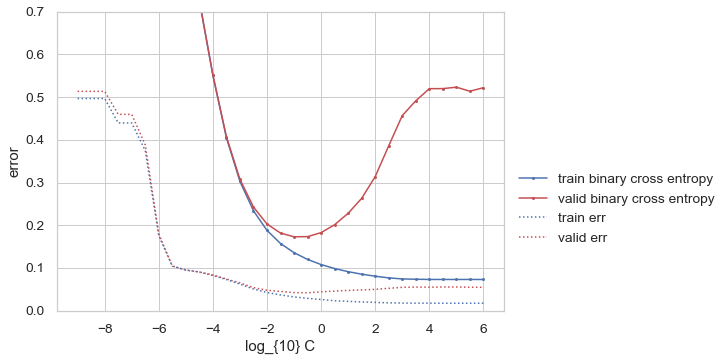

In [202]:
print(len(convoluted_training_x_tr))
print(len(convoluted_test_x_tr))
print(convoluted_training_x_tr[0].shape)

convoluted_training_x_tr = np.asarray(convoluted_training_x_tr)
convoluted_test_x_tr = np.asarray(convoluted_test_x_tr)
compute_results_model_on(convoluted_training_x_tr, convoluted_test_x_tr, 'edge detection convolution model')

training iter 0
Filter  1
Filter  2
training iter 1
Filter  1
Filter  2
training iter 2
Filter  1
Filter  2
training iter 3
Filter  1
Filter  2
training iter 4
Filter  1
Filter  2
training iter 5
Filter  1
Filter  2
training iter 6
Filter  1
Filter  2
training iter 7
Filter  1
Filter  2
training iter 8
Filter  1
Filter  2
training iter 9
Filter  1
Filter  2
training iter 10
Filter  1
Filter  2
training iter 11
Filter  1
Filter  2
training iter 12
Filter  1
Filter  2
training iter 13
Filter  1
Filter  2
training iter 14
Filter  1
Filter  2
training iter 15
Filter  1
Filter  2
training iter 16
Filter  1
Filter  2
training iter 17
Filter  1
Filter  2
training iter 18
Filter  1
Filter  2
training iter 19
Filter  1
Filter  2
training iter 20
Filter  1
Filter  2
training iter 21
Filter  1
Filter  2
training iter 22
Filter  1
Filter  2
training iter 23
Filter  1
Filter  2
training iter 24
Filter  1
Filter  2
training iter 25
Filter  1
Filter  2
training iter 26
Filter  1
Filter  2
training it

training iter 227
Filter  1
Filter  2
training iter 228
Filter  1
Filter  2
training iter 229
Filter  1
Filter  2
training iter 230
Filter  1
Filter  2
training iter 231
Filter  1
Filter  2
training iter 232
Filter  1
Filter  2
training iter 233
Filter  1
Filter  2
training iter 234
Filter  1
Filter  2
training iter 235
Filter  1
Filter  2
training iter 236
Filter  1
Filter  2
training iter 237
Filter  1
Filter  2
training iter 238
Filter  1
Filter  2
training iter 239
Filter  1
Filter  2
training iter 240
Filter  1
Filter  2
training iter 241
Filter  1
Filter  2
training iter 242
Filter  1
Filter  2
training iter 243
Filter  1
Filter  2
training iter 244
Filter  1
Filter  2
training iter 245
Filter  1
Filter  2
training iter 246
Filter  1
Filter  2
training iter 247
Filter  1
Filter  2
training iter 248
Filter  1
Filter  2
training iter 249
Filter  1
Filter  2
training iter 250
Filter  1
Filter  2
training iter 251
Filter  1
Filter  2
training iter 252
Filter  1
Filter  2
training ite

training iter 449
Filter  1
Filter  2
training iter 450
Filter  1
Filter  2
training iter 451
Filter  1
Filter  2
training iter 452
Filter  1
Filter  2
training iter 453
Filter  1
Filter  2
training iter 454
Filter  1
Filter  2
training iter 455
Filter  1
Filter  2
training iter 456
Filter  1
Filter  2
training iter 457
Filter  1
Filter  2
training iter 458
Filter  1
Filter  2
training iter 459
Filter  1
Filter  2
training iter 460
Filter  1
Filter  2
training iter 461
Filter  1
Filter  2
training iter 462
Filter  1
Filter  2
training iter 463
Filter  1
Filter  2
training iter 464
Filter  1
Filter  2
training iter 465
Filter  1
Filter  2
training iter 466
Filter  1
Filter  2
training iter 467
Filter  1
Filter  2
training iter 468
Filter  1
Filter  2
training iter 469
Filter  1
Filter  2
training iter 470
Filter  1
Filter  2
training iter 471
Filter  1
Filter  2
training iter 472
Filter  1
Filter  2
training iter 473
Filter  1
Filter  2
training iter 474
Filter  1
Filter  2
training ite

training iter 676
Filter  1
Filter  2
training iter 677
Filter  1
Filter  2
training iter 678
Filter  1
Filter  2
training iter 679
Filter  1
Filter  2
training iter 680
Filter  1
Filter  2
training iter 681
Filter  1
Filter  2
training iter 682
Filter  1
Filter  2
training iter 683
Filter  1
Filter  2
training iter 684
Filter  1
Filter  2
training iter 685
Filter  1
Filter  2
training iter 686
Filter  1
Filter  2
training iter 687
Filter  1
Filter  2
training iter 688
Filter  1
Filter  2
training iter 689
Filter  1
Filter  2
training iter 690
Filter  1
Filter  2
training iter 691
Filter  1
Filter  2
training iter 692
Filter  1
Filter  2
training iter 693
Filter  1
Filter  2
training iter 694
Filter  1
Filter  2
training iter 695
Filter  1
Filter  2
training iter 696
Filter  1
Filter  2
training iter 697
Filter  1
Filter  2
training iter 698
Filter  1
Filter  2
training iter 699
Filter  1
Filter  2
training iter 700
Filter  1
Filter  2
training iter 701
Filter  1
Filter  2
training ite

Filter  2
training iter 898
Filter  1
Filter  2
training iter 899
Filter  1
Filter  2
training iter 900
Filter  1
Filter  2
training iter 901
Filter  1
Filter  2
training iter 902
Filter  1
Filter  2
training iter 903
Filter  1
Filter  2
training iter 904
Filter  1
Filter  2
training iter 905
Filter  1
Filter  2
training iter 906
Filter  1
Filter  2
training iter 907
Filter  1
Filter  2
training iter 908
Filter  1
Filter  2
training iter 909
Filter  1
Filter  2
training iter 910
Filter  1
Filter  2
training iter 911
Filter  1
Filter  2
training iter 912
Filter  1
Filter  2
training iter 913
Filter  1
Filter  2
training iter 914
Filter  1
Filter  2
training iter 915
Filter  1
Filter  2
training iter 916
Filter  1
Filter  2
training iter 917
Filter  1
Filter  2
training iter 918
Filter  1
Filter  2
training iter 919
Filter  1
Filter  2
training iter 920
Filter  1
Filter  2
training iter 921
Filter  1
Filter  2
training iter 922
Filter  1
Filter  2
training iter 923
Filter  1
Filter  2
tr

Filter  2
training iter 1111
Filter  1
Filter  2
training iter 1112
Filter  1
Filter  2
training iter 1113
Filter  1
Filter  2
training iter 1114
Filter  1
Filter  2
training iter 1115
Filter  1
Filter  2
training iter 1116
Filter  1
Filter  2
training iter 1117
Filter  1
Filter  2
training iter 1118
Filter  1
Filter  2
training iter 1119
Filter  1
Filter  2
training iter 1120
Filter  1
Filter  2
training iter 1121
Filter  1
Filter  2
training iter 1122
Filter  1
Filter  2
training iter 1123
Filter  1
Filter  2
training iter 1124
Filter  1
Filter  2
training iter 1125
Filter  1
Filter  2
training iter 1126
Filter  1
Filter  2
training iter 1127
Filter  1
Filter  2
training iter 1128
Filter  1
Filter  2
training iter 1129
Filter  1
Filter  2
training iter 1130
Filter  1
Filter  2
training iter 1131
Filter  1
Filter  2
training iter 1132
Filter  1
Filter  2
training iter 1133
Filter  1
Filter  2
training iter 1134
Filter  1
Filter  2
training iter 1135
Filter  1
Filter  2
training iter 1

training iter 1323
Filter  1
Filter  2
training iter 1324
Filter  1
Filter  2
training iter 1325
Filter  1
Filter  2
training iter 1326
Filter  1
Filter  2
training iter 1327
Filter  1
Filter  2
training iter 1328
Filter  1
Filter  2
training iter 1329
Filter  1
Filter  2
training iter 1330
Filter  1
Filter  2
training iter 1331
Filter  1
Filter  2
training iter 1332
Filter  1
Filter  2
training iter 1333
Filter  1
Filter  2
training iter 1334
Filter  1
Filter  2
training iter 1335
Filter  1
Filter  2
training iter 1336
Filter  1
Filter  2
training iter 1337
Filter  1
Filter  2
training iter 1338
Filter  1
Filter  2
training iter 1339
Filter  1
Filter  2
training iter 1340
Filter  1
Filter  2
training iter 1341
Filter  1
Filter  2
training iter 1342
Filter  1
Filter  2
training iter 1343
Filter  1
Filter  2
training iter 1344
Filter  1
Filter  2
training iter 1345
Filter  1
Filter  2
training iter 1346
Filter  1
Filter  2
training iter 1347
Filter  1
Filter  2
training iter 1348
Filter

training iter 1540
Filter  1
Filter  2
training iter 1541
Filter  1
Filter  2
training iter 1542
Filter  1
Filter  2
training iter 1543
Filter  1
Filter  2
training iter 1544
Filter  1
Filter  2
training iter 1545
Filter  1
Filter  2
training iter 1546
Filter  1
Filter  2
training iter 1547
Filter  1
Filter  2
training iter 1548
Filter  1
Filter  2
training iter 1549
Filter  1
Filter  2
training iter 1550
Filter  1
Filter  2
training iter 1551
Filter  1
Filter  2
training iter 1552
Filter  1
Filter  2
training iter 1553
Filter  1
Filter  2
training iter 1554
Filter  1
Filter  2
training iter 1555
Filter  1
Filter  2
training iter 1556
Filter  1
Filter  2
training iter 1557
Filter  1
Filter  2
training iter 1558
Filter  1
Filter  2
training iter 1559
Filter  1
Filter  2
training iter 1560
Filter  1
Filter  2
training iter 1561
Filter  1
Filter  2
training iter 1562
Filter  1
Filter  2
training iter 1563
Filter  1
Filter  2
training iter 1564
Filter  1
Filter  2
training iter 1565
Filter

Filter  2
training iter 1756
Filter  1
Filter  2
training iter 1757
Filter  1
Filter  2
training iter 1758
Filter  1
Filter  2
training iter 1759
Filter  1
Filter  2
training iter 1760
Filter  1
Filter  2
training iter 1761
Filter  1
Filter  2
training iter 1762
Filter  1
Filter  2
training iter 1763
Filter  1
Filter  2
training iter 1764
Filter  1
Filter  2
training iter 1765
Filter  1
Filter  2
training iter 1766
Filter  1
Filter  2
training iter 1767
Filter  1
Filter  2
training iter 1768
Filter  1
Filter  2
training iter 1769
Filter  1
Filter  2
training iter 1770
Filter  1
Filter  2
training iter 1771
Filter  1
Filter  2
training iter 1772
Filter  1
Filter  2
training iter 1773
Filter  1
Filter  2
training iter 1774
Filter  1
Filter  2
training iter 1775
Filter  1
Filter  2
training iter 1776
Filter  1
Filter  2
training iter 1777
Filter  1
Filter  2
training iter 1778
Filter  1
Filter  2
training iter 1779
Filter  1
Filter  2
training iter 1780
Filter  1
Filter  2
training iter 1

Filter  2
training iter 1967
Filter  1
Filter  2
training iter 1968
Filter  1
Filter  2
training iter 1969
Filter  1
Filter  2
training iter 1970
Filter  1
Filter  2
training iter 1971
Filter  1
Filter  2
training iter 1972
Filter  1
Filter  2
training iter 1973
Filter  1
Filter  2
training iter 1974
Filter  1
Filter  2
training iter 1975
Filter  1
Filter  2
training iter 1976
Filter  1
Filter  2
training iter 1977
Filter  1
Filter  2
training iter 1978
Filter  1
Filter  2
training iter 1979
Filter  1
Filter  2
training iter 1980
Filter  1
Filter  2
training iter 1981
Filter  1
Filter  2
training iter 1982
Filter  1
Filter  2
training iter 1983
Filter  1
Filter  2
training iter 1984
Filter  1
Filter  2
training iter 1985
Filter  1
Filter  2
training iter 1986
Filter  1
Filter  2
training iter 1987
Filter  1
Filter  2
training iter 1988
Filter  1
Filter  2
training iter 1989
Filter  1
Filter  2
training iter 1990
Filter  1
Filter  2
training iter 1991
Filter  1
Filter  2
training iter 1

Filter  2
training iter 2181
Filter  1
Filter  2
training iter 2182
Filter  1
Filter  2
training iter 2183
Filter  1
Filter  2
training iter 2184
Filter  1
Filter  2
training iter 2185
Filter  1
Filter  2
training iter 2186
Filter  1
Filter  2
training iter 2187
Filter  1
Filter  2
training iter 2188
Filter  1
Filter  2
training iter 2189
Filter  1
Filter  2
training iter 2190
Filter  1
Filter  2
training iter 2191
Filter  1
Filter  2
training iter 2192
Filter  1
Filter  2
training iter 2193
Filter  1
Filter  2
training iter 2194
Filter  1
Filter  2
training iter 2195
Filter  1
Filter  2
training iter 2196
Filter  1
Filter  2
training iter 2197
Filter  1
Filter  2
training iter 2198
Filter  1
Filter  2
training iter 2199
Filter  1
Filter  2
training iter 2200
Filter  1
Filter  2
training iter 2201
Filter  1
Filter  2
training iter 2202
Filter  1
Filter  2
training iter 2203
Filter  1
Filter  2
training iter 2204
Filter  1
Filter  2
training iter 2205
Filter  1
Filter  2
training iter 2

Filter  2
training iter 2397
Filter  1
Filter  2
training iter 2398
Filter  1
Filter  2
training iter 2399
Filter  1
Filter  2
training iter 2400
Filter  1
Filter  2
training iter 2401
Filter  1
Filter  2
training iter 2402
Filter  1
Filter  2
training iter 2403
Filter  1
Filter  2
training iter 2404
Filter  1
Filter  2
training iter 2405
Filter  1
Filter  2
training iter 2406
Filter  1
Filter  2
training iter 2407
Filter  1
Filter  2
training iter 2408
Filter  1
Filter  2
training iter 2409
Filter  1
Filter  2
training iter 2410
Filter  1
Filter  2
training iter 2411
Filter  1
Filter  2
training iter 2412
Filter  1
Filter  2
training iter 2413
Filter  1
Filter  2
training iter 2414
Filter  1
Filter  2
training iter 2415
Filter  1
Filter  2
training iter 2416
Filter  1
Filter  2
training iter 2417
Filter  1
Filter  2
training iter 2418
Filter  1
Filter  2
training iter 2419
Filter  1
Filter  2
training iter 2420
Filter  1
Filter  2
training iter 2421
Filter  1
Filter  2
training iter 2

training iter 2616
Filter  1
Filter  2
training iter 2617
Filter  1
Filter  2
training iter 2618
Filter  1
Filter  2
training iter 2619
Filter  1
Filter  2
training iter 2620
Filter  1
Filter  2
training iter 2621
Filter  1
Filter  2
training iter 2622
Filter  1
Filter  2
training iter 2623
Filter  1
Filter  2
training iter 2624
Filter  1
Filter  2
training iter 2625
Filter  1
Filter  2
training iter 2626
Filter  1
Filter  2
training iter 2627
Filter  1
Filter  2
training iter 2628
Filter  1
Filter  2
training iter 2629
Filter  1
Filter  2
training iter 2630
Filter  1
Filter  2
training iter 2631
Filter  1
Filter  2
training iter 2632
Filter  1
Filter  2
training iter 2633
Filter  1
Filter  2
training iter 2634
Filter  1
Filter  2
training iter 2635
Filter  1
Filter  2
training iter 2636
Filter  1
Filter  2
training iter 2637
Filter  1
Filter  2
training iter 2638
Filter  1
Filter  2
training iter 2639
Filter  1
Filter  2
training iter 2640
Filter  1
Filter  2
training iter 2641
Filter

Filter  1
Filter  2
training iter 2837
Filter  1
Filter  2
training iter 2838
Filter  1
Filter  2
training iter 2839
Filter  1
Filter  2
training iter 2840
Filter  1
Filter  2
training iter 2841
Filter  1
Filter  2
training iter 2842
Filter  1
Filter  2
training iter 2843
Filter  1
Filter  2
training iter 2844
Filter  1
Filter  2
training iter 2845
Filter  1
Filter  2
training iter 2846
Filter  1
Filter  2
training iter 2847
Filter  1
Filter  2
training iter 2848
Filter  1
Filter  2
training iter 2849
Filter  1
Filter  2
training iter 2850
Filter  1
Filter  2
training iter 2851
Filter  1
Filter  2
training iter 2852
Filter  1
Filter  2
training iter 2853
Filter  1
Filter  2
training iter 2854
Filter  1
Filter  2
training iter 2855
Filter  1
Filter  2
training iter 2856
Filter  1
Filter  2
training iter 2857
Filter  1
Filter  2
training iter 2858
Filter  1
Filter  2
training iter 2859
Filter  1
Filter  2
training iter 2860
Filter  1
Filter  2
training iter 2861
Filter  1
Filter  2
train

Filter  2
training iter 3054
Filter  1
Filter  2
training iter 3055
Filter  1
Filter  2
training iter 3056
Filter  1
Filter  2
training iter 3057
Filter  1
Filter  2
training iter 3058
Filter  1
Filter  2
training iter 3059
Filter  1
Filter  2
training iter 3060
Filter  1
Filter  2
training iter 3061
Filter  1
Filter  2
training iter 3062
Filter  1
Filter  2
training iter 3063
Filter  1
Filter  2
training iter 3064
Filter  1
Filter  2
training iter 3065
Filter  1
Filter  2
training iter 3066
Filter  1
Filter  2
training iter 3067
Filter  1
Filter  2
training iter 3068
Filter  1
Filter  2
training iter 3069
Filter  1
Filter  2
training iter 3070
Filter  1
Filter  2
training iter 3071
Filter  1
Filter  2
training iter 3072
Filter  1
Filter  2
training iter 3073
Filter  1
Filter  2
training iter 3074
Filter  1
Filter  2
training iter 3075
Filter  1
Filter  2
training iter 3076
Filter  1
Filter  2
training iter 3077
Filter  1
Filter  2
training iter 3078
Filter  1
Filter  2
training iter 3

training iter 3265
Filter  1
Filter  2
training iter 3266
Filter  1
Filter  2
training iter 3267
Filter  1
Filter  2
training iter 3268
Filter  1
Filter  2
training iter 3269
Filter  1
Filter  2
training iter 3270
Filter  1
Filter  2
training iter 3271
Filter  1
Filter  2
training iter 3272
Filter  1
Filter  2
training iter 3273
Filter  1
Filter  2
training iter 3274
Filter  1
Filter  2
training iter 3275
Filter  1
Filter  2
training iter 3276
Filter  1
Filter  2
training iter 3277
Filter  1
Filter  2
training iter 3278
Filter  1
Filter  2
training iter 3279
Filter  1
Filter  2
training iter 3280
Filter  1
Filter  2
training iter 3281
Filter  1
Filter  2
training iter 3282
Filter  1
Filter  2
training iter 3283
Filter  1
Filter  2
training iter 3284
Filter  1
Filter  2
training iter 3285
Filter  1
Filter  2
training iter 3286
Filter  1
Filter  2
training iter 3287
Filter  1
Filter  2
training iter 3288
Filter  1
Filter  2
training iter 3289
Filter  1
Filter  2
training iter 3290
Filter

Filter  2
training iter 3482
Filter  1
Filter  2
training iter 3483
Filter  1
Filter  2
training iter 3484
Filter  1
Filter  2
training iter 3485
Filter  1
Filter  2
training iter 3486
Filter  1
Filter  2
training iter 3487
Filter  1
Filter  2
training iter 3488
Filter  1
Filter  2
training iter 3489
Filter  1
Filter  2
training iter 3490
Filter  1
Filter  2
training iter 3491
Filter  1
Filter  2
training iter 3492
Filter  1
Filter  2
training iter 3493
Filter  1
Filter  2
training iter 3494
Filter  1
Filter  2
training iter 3495
Filter  1
Filter  2
training iter 3496
Filter  1
Filter  2
training iter 3497
Filter  1
Filter  2
training iter 3498
Filter  1
Filter  2
training iter 3499
Filter  1
Filter  2
training iter 3500
Filter  1
Filter  2
training iter 3501
Filter  1
Filter  2
training iter 3502
Filter  1
Filter  2
training iter 3503
Filter  1
Filter  2
training iter 3504
Filter  1
Filter  2
training iter 3505
Filter  1
Filter  2
training iter 3506
Filter  1
Filter  2
training iter 3

Filter  2
training iter 3694
Filter  1
Filter  2
training iter 3695
Filter  1
Filter  2
training iter 3696
Filter  1
Filter  2
training iter 3697
Filter  1
Filter  2
training iter 3698
Filter  1
Filter  2
training iter 3699
Filter  1
Filter  2
training iter 3700
Filter  1
Filter  2
training iter 3701
Filter  1
Filter  2
training iter 3702
Filter  1
Filter  2
training iter 3703
Filter  1
Filter  2
training iter 3704
Filter  1
Filter  2
training iter 3705
Filter  1
Filter  2
training iter 3706
Filter  1
Filter  2
training iter 3707
Filter  1
Filter  2
training iter 3708
Filter  1
Filter  2
training iter 3709
Filter  1
Filter  2
training iter 3710
Filter  1
Filter  2
training iter 3711
Filter  1
Filter  2
training iter 3712
Filter  1
Filter  2
training iter 3713
Filter  1
Filter  2
training iter 3714
Filter  1
Filter  2
training iter 3715
Filter  1
Filter  2
training iter 3716
Filter  1
Filter  2
training iter 3717
Filter  1
Filter  2
training iter 3718
Filter  1
Filter  2
training iter 3

training iter 3904
Filter  1
Filter  2
training iter 3905
Filter  1
Filter  2
training iter 3906
Filter  1
Filter  2
training iter 3907
Filter  1
Filter  2
training iter 3908
Filter  1
Filter  2
training iter 3909
Filter  1
Filter  2
training iter 3910
Filter  1
Filter  2
training iter 3911
Filter  1
Filter  2
training iter 3912
Filter  1
Filter  2
training iter 3913
Filter  1
Filter  2
training iter 3914
Filter  1
Filter  2
training iter 3915
Filter  1
Filter  2
training iter 3916
Filter  1
Filter  2
training iter 3917
Filter  1
Filter  2
training iter 3918
Filter  1
Filter  2
training iter 3919
Filter  1
Filter  2
training iter 3920
Filter  1
Filter  2
training iter 3921
Filter  1
Filter  2
training iter 3922
Filter  1
Filter  2
training iter 3923
Filter  1
Filter  2
training iter 3924
Filter  1
Filter  2
training iter 3925
Filter  1
Filter  2
training iter 3926
Filter  1
Filter  2
training iter 3927
Filter  1
Filter  2
training iter 3928
Filter  1
Filter  2
training iter 3929
Filter

training iter 4116
Filter  1
Filter  2
training iter 4117
Filter  1
Filter  2
training iter 4118
Filter  1
Filter  2
training iter 4119
Filter  1
Filter  2
training iter 4120
Filter  1
Filter  2
training iter 4121
Filter  1
Filter  2
training iter 4122
Filter  1
Filter  2
training iter 4123
Filter  1
Filter  2
training iter 4124
Filter  1
Filter  2
training iter 4125
Filter  1
Filter  2
training iter 4126
Filter  1
Filter  2
training iter 4127
Filter  1
Filter  2
training iter 4128
Filter  1
Filter  2
training iter 4129
Filter  1
Filter  2
training iter 4130
Filter  1
Filter  2
training iter 4131
Filter  1
Filter  2
training iter 4132
Filter  1
Filter  2
training iter 4133
Filter  1
Filter  2
training iter 4134
Filter  1
Filter  2
training iter 4135
Filter  1
Filter  2
training iter 4136
Filter  1
Filter  2
training iter 4137
Filter  1
Filter  2
training iter 4138
Filter  1
Filter  2
training iter 4139
Filter  1
Filter  2
training iter 4140
Filter  1
Filter  2
training iter 4141
Filter

Filter  2
training iter 4332
Filter  1
Filter  2
training iter 4333
Filter  1
Filter  2
training iter 4334
Filter  1
Filter  2
training iter 4335
Filter  1
Filter  2
training iter 4336
Filter  1
Filter  2
training iter 4337
Filter  1
Filter  2
training iter 4338
Filter  1
Filter  2
training iter 4339
Filter  1
Filter  2
training iter 4340
Filter  1
Filter  2
training iter 4341
Filter  1
Filter  2
training iter 4342
Filter  1
Filter  2
training iter 4343
Filter  1
Filter  2
training iter 4344
Filter  1
Filter  2
training iter 4345
Filter  1
Filter  2
training iter 4346
Filter  1
Filter  2
training iter 4347
Filter  1
Filter  2
training iter 4348
Filter  1
Filter  2
training iter 4349
Filter  1
Filter  2
training iter 4350
Filter  1
Filter  2
training iter 4351
Filter  1
Filter  2
training iter 4352
Filter  1
Filter  2
training iter 4353
Filter  1
Filter  2
training iter 4354
Filter  1
Filter  2
training iter 4355
Filter  1
Filter  2
training iter 4356
Filter  1
Filter  2
training iter 4

Filter  1
Filter  2
training iter 4556
Filter  1
Filter  2
training iter 4557
Filter  1
Filter  2
training iter 4558
Filter  1
Filter  2
training iter 4559
Filter  1
Filter  2
training iter 4560
Filter  1
Filter  2
training iter 4561
Filter  1
Filter  2
training iter 4562
Filter  1
Filter  2
training iter 4563
Filter  1
Filter  2
training iter 4564
Filter  1
Filter  2
training iter 4565
Filter  1
Filter  2
training iter 4566
Filter  1
Filter  2
training iter 4567
Filter  1
Filter  2
training iter 4568
Filter  1
Filter  2
training iter 4569
Filter  1
Filter  2
training iter 4570
Filter  1
Filter  2
training iter 4571
Filter  1
Filter  2
training iter 4572
Filter  1
Filter  2
training iter 4573
Filter  1
Filter  2
training iter 4574
Filter  1
Filter  2
training iter 4575
Filter  1
Filter  2
training iter 4576
Filter  1
Filter  2
training iter 4577
Filter  1
Filter  2
training iter 4578
Filter  1
Filter  2
training iter 4579
Filter  1
Filter  2
training iter 4580
Filter  1
Filter  2
train

Filter  2
training iter 4769
Filter  1
Filter  2
training iter 4770
Filter  1
Filter  2
training iter 4771
Filter  1
Filter  2
training iter 4772
Filter  1
Filter  2
training iter 4773
Filter  1
Filter  2
training iter 4774
Filter  1
Filter  2
training iter 4775
Filter  1
Filter  2
training iter 4776
Filter  1
Filter  2
training iter 4777
Filter  1
Filter  2
training iter 4778
Filter  1
Filter  2
training iter 4779
Filter  1
Filter  2
training iter 4780
Filter  1
Filter  2
training iter 4781
Filter  1
Filter  2
training iter 4782
Filter  1
Filter  2
training iter 4783
Filter  1
Filter  2
training iter 4784
Filter  1
Filter  2
training iter 4785
Filter  1
Filter  2
training iter 4786
Filter  1
Filter  2
training iter 4787
Filter  1
Filter  2
training iter 4788
Filter  1
Filter  2
training iter 4789
Filter  1
Filter  2
training iter 4790
Filter  1
Filter  2
training iter 4791
Filter  1
Filter  2
training iter 4792
Filter  1
Filter  2
training iter 4793
Filter  1
Filter  2
training iter 4

training iter 4981
Filter  1
Filter  2
training iter 4982
Filter  1
Filter  2
training iter 4983
Filter  1
Filter  2
training iter 4984
Filter  1
Filter  2
training iter 4985
Filter  1
Filter  2
training iter 4986
Filter  1
Filter  2
training iter 4987
Filter  1
Filter  2
training iter 4988
Filter  1
Filter  2
training iter 4989
Filter  1
Filter  2
training iter 4990
Filter  1
Filter  2
training iter 4991
Filter  1
Filter  2
training iter 4992
Filter  1
Filter  2
training iter 4993
Filter  1
Filter  2
training iter 4994
Filter  1
Filter  2
training iter 4995
Filter  1
Filter  2
training iter 4996
Filter  1
Filter  2
training iter 4997
Filter  1
Filter  2
training iter 4998
Filter  1
Filter  2
training iter 4999
Filter  1
Filter  2
training iter 5000
Filter  1
Filter  2
training iter 5001
Filter  1
Filter  2
training iter 5002
Filter  1
Filter  2
training iter 5003
Filter  1
Filter  2
training iter 5004
Filter  1
Filter  2
training iter 5005
Filter  1
Filter  2
training iter 5006
Filter

Filter  2
training iter 5199
Filter  1
Filter  2
training iter 5200
Filter  1
Filter  2
training iter 5201
Filter  1
Filter  2
training iter 5202
Filter  1
Filter  2
training iter 5203
Filter  1
Filter  2
training iter 5204
Filter  1
Filter  2
training iter 5205
Filter  1
Filter  2
training iter 5206
Filter  1
Filter  2
training iter 5207
Filter  1
Filter  2
training iter 5208
Filter  1
Filter  2
training iter 5209
Filter  1
Filter  2
training iter 5210
Filter  1
Filter  2
training iter 5211
Filter  1
Filter  2
training iter 5212
Filter  1
Filter  2
training iter 5213
Filter  1
Filter  2
training iter 5214
Filter  1
Filter  2
training iter 5215
Filter  1
Filter  2
training iter 5216
Filter  1
Filter  2
training iter 5217
Filter  1
Filter  2
training iter 5218
Filter  1
Filter  2
training iter 5219
Filter  1
Filter  2
training iter 5220
Filter  1
Filter  2
training iter 5221
Filter  1
Filter  2
training iter 5222
Filter  1
Filter  2
training iter 5223
Filter  1
Filter  2
training iter 5

Filter  2
training iter 5415
Filter  1
Filter  2
training iter 5416
Filter  1
Filter  2
training iter 5417
Filter  1
Filter  2
training iter 5418
Filter  1
Filter  2
training iter 5419
Filter  1
Filter  2
training iter 5420
Filter  1
Filter  2
training iter 5421
Filter  1
Filter  2
training iter 5422
Filter  1
Filter  2
training iter 5423
Filter  1
Filter  2
training iter 5424
Filter  1
Filter  2
training iter 5425
Filter  1
Filter  2
training iter 5426
Filter  1
Filter  2
training iter 5427
Filter  1
Filter  2
training iter 5428
Filter  1
Filter  2
training iter 5429
Filter  1
Filter  2
training iter 5430
Filter  1
Filter  2
training iter 5431
Filter  1
Filter  2
training iter 5432
Filter  1
Filter  2
training iter 5433
Filter  1
Filter  2
training iter 5434
Filter  1
Filter  2
training iter 5435
Filter  1
Filter  2
training iter 5436
Filter  1
Filter  2
training iter 5437
Filter  1
Filter  2
training iter 5438
Filter  1
Filter  2
training iter 5439
Filter  1
Filter  2
training iter 5

Filter  2
training iter 5630
Filter  1
Filter  2
training iter 5631
Filter  1
Filter  2
training iter 5632
Filter  1
Filter  2
training iter 5633
Filter  1
Filter  2
training iter 5634
Filter  1
Filter  2
training iter 5635
Filter  1
Filter  2
training iter 5636
Filter  1
Filter  2
training iter 5637
Filter  1
Filter  2
training iter 5638
Filter  1
Filter  2
training iter 5639
Filter  1
Filter  2
training iter 5640
Filter  1
Filter  2
training iter 5641
Filter  1
Filter  2
training iter 5642
Filter  1
Filter  2
training iter 5643
Filter  1
Filter  2
training iter 5644
Filter  1
Filter  2
training iter 5645
Filter  1
Filter  2
training iter 5646
Filter  1
Filter  2
training iter 5647
Filter  1
Filter  2
training iter 5648
Filter  1
Filter  2
training iter 5649
Filter  1
Filter  2
training iter 5650
Filter  1
Filter  2
training iter 5651
Filter  1
Filter  2
training iter 5652
Filter  1
Filter  2
training iter 5653
Filter  1
Filter  2
training iter 5654
Filter  1
Filter  2
training iter 5

training iter 5841
Filter  1
Filter  2
training iter 5842
Filter  1
Filter  2
training iter 5843
Filter  1
Filter  2
training iter 5844
Filter  1
Filter  2
training iter 5845
Filter  1
Filter  2
training iter 5846
Filter  1
Filter  2
training iter 5847
Filter  1
Filter  2
training iter 5848
Filter  1
Filter  2
training iter 5849
Filter  1
Filter  2
training iter 5850
Filter  1
Filter  2
training iter 5851
Filter  1
Filter  2
training iter 5852
Filter  1
Filter  2
training iter 5853
Filter  1
Filter  2
training iter 5854
Filter  1
Filter  2
training iter 5855
Filter  1
Filter  2
training iter 5856
Filter  1
Filter  2
training iter 5857
Filter  1
Filter  2
training iter 5858
Filter  1
Filter  2
training iter 5859
Filter  1
Filter  2
training iter 5860
Filter  1
Filter  2
training iter 5861
Filter  1
Filter  2
training iter 5862
Filter  1
Filter  2
training iter 5863
Filter  1
Filter  2
training iter 5864
Filter  1
Filter  2
training iter 5865
Filter  1
Filter  2
training iter 5866
Filter

training iter 6058
Filter  1
Filter  2
training iter 6059
Filter  1
Filter  2
training iter 6060
Filter  1
Filter  2
training iter 6061
Filter  1
Filter  2
training iter 6062
Filter  1
Filter  2
training iter 6063
Filter  1
Filter  2
training iter 6064
Filter  1
Filter  2
training iter 6065
Filter  1
Filter  2
training iter 6066
Filter  1
Filter  2
training iter 6067
Filter  1
Filter  2
training iter 6068
Filter  1
Filter  2
training iter 6069
Filter  1
Filter  2
training iter 6070
Filter  1
Filter  2
training iter 6071
Filter  1
Filter  2
training iter 6072
Filter  1
Filter  2
training iter 6073
Filter  1
Filter  2
training iter 6074
Filter  1
Filter  2
training iter 6075
Filter  1
Filter  2
training iter 6076
Filter  1
Filter  2
training iter 6077
Filter  1
Filter  2
training iter 6078
Filter  1
Filter  2
training iter 6079
Filter  1
Filter  2
training iter 6080
Filter  1
Filter  2
training iter 6081
Filter  1
Filter  2
training iter 6082
Filter  1
Filter  2
training iter 6083
Filter

training iter 6281
Filter  1
Filter  2
training iter 6282
Filter  1
Filter  2
training iter 6283
Filter  1
Filter  2
training iter 6284
Filter  1
Filter  2
training iter 6285
Filter  1
Filter  2
training iter 6286
Filter  1
Filter  2
training iter 6287
Filter  1
Filter  2
training iter 6288
Filter  1
Filter  2
training iter 6289
Filter  1
Filter  2
training iter 6290
Filter  1
Filter  2
training iter 6291
Filter  1
Filter  2
training iter 6292
Filter  1
Filter  2
training iter 6293
Filter  1
Filter  2
training iter 6294
Filter  1
Filter  2
training iter 6295
Filter  1
Filter  2
training iter 6296
Filter  1
Filter  2
training iter 6297
Filter  1
Filter  2
training iter 6298
Filter  1
Filter  2
training iter 6299
Filter  1
Filter  2
training iter 6300
Filter  1
Filter  2
training iter 6301
Filter  1
Filter  2
training iter 6302
Filter  1
Filter  2
training iter 6303
Filter  1
Filter  2
training iter 6304
Filter  1
Filter  2
training iter 6305
Filter  1
Filter  2
training iter 6306
Filter

Filter  2
training iter 6503
Filter  1
Filter  2
training iter 6504
Filter  1
Filter  2
training iter 6505
Filter  1
Filter  2
training iter 6506
Filter  1
Filter  2
training iter 6507
Filter  1
Filter  2
training iter 6508
Filter  1
Filter  2
training iter 6509
Filter  1
Filter  2
training iter 6510
Filter  1
Filter  2
training iter 6511
Filter  1
Filter  2
training iter 6512
Filter  1
Filter  2
training iter 6513
Filter  1
Filter  2
training iter 6514
Filter  1
Filter  2
training iter 6515
Filter  1
Filter  2
training iter 6516
Filter  1
Filter  2
training iter 6517
Filter  1
Filter  2
training iter 6518
Filter  1
Filter  2
training iter 6519
Filter  1
Filter  2
training iter 6520
Filter  1
Filter  2
training iter 6521
Filter  1
Filter  2
training iter 6522
Filter  1
Filter  2
training iter 6523
Filter  1
Filter  2
training iter 6524
Filter  1
Filter  2
training iter 6525
Filter  1
Filter  2
training iter 6526
Filter  1
Filter  2
training iter 6527
Filter  1
Filter  2
training iter 6

training iter 6714
Filter  1
Filter  2
training iter 6715
Filter  1
Filter  2
training iter 6716
Filter  1
Filter  2
training iter 6717
Filter  1
Filter  2
training iter 6718
Filter  1
Filter  2
training iter 6719
Filter  1
Filter  2
training iter 6720
Filter  1
Filter  2
training iter 6721
Filter  1
Filter  2
training iter 6722
Filter  1
Filter  2
training iter 6723
Filter  1
Filter  2
training iter 6724
Filter  1
Filter  2
training iter 6725
Filter  1
Filter  2
training iter 6726
Filter  1
Filter  2
training iter 6727
Filter  1
Filter  2
training iter 6728
Filter  1
Filter  2
training iter 6729
Filter  1
Filter  2
training iter 6730
Filter  1
Filter  2
training iter 6731
Filter  1
Filter  2
training iter 6732
Filter  1
Filter  2
training iter 6733
Filter  1
Filter  2
training iter 6734
Filter  1
Filter  2
training iter 6735
Filter  1
Filter  2
training iter 6736
Filter  1
Filter  2
training iter 6737
Filter  1
Filter  2
training iter 6738
Filter  1
Filter  2
training iter 6739
Filter

Filter  2
training iter 6926
Filter  1
Filter  2
training iter 6927
Filter  1
Filter  2
training iter 6928
Filter  1
Filter  2
training iter 6929
Filter  1
Filter  2
training iter 6930
Filter  1
Filter  2
training iter 6931
Filter  1
Filter  2
training iter 6932
Filter  1
Filter  2
training iter 6933
Filter  1
Filter  2
training iter 6934
Filter  1
Filter  2
training iter 6935
Filter  1
Filter  2
training iter 6936
Filter  1
Filter  2
training iter 6937
Filter  1
Filter  2
training iter 6938
Filter  1
Filter  2
training iter 6939
Filter  1
Filter  2
training iter 6940
Filter  1
Filter  2
training iter 6941
Filter  1
Filter  2
training iter 6942
Filter  1
Filter  2
training iter 6943
Filter  1
Filter  2
training iter 6944
Filter  1
Filter  2
training iter 6945
Filter  1
Filter  2
training iter 6946
Filter  1
Filter  2
training iter 6947
Filter  1
Filter  2
training iter 6948
Filter  1
Filter  2
training iter 6949
Filter  1
Filter  2
training iter 6950
Filter  1
Filter  2
training iter 6

training iter 7141
Filter  1
Filter  2
training iter 7142
Filter  1
Filter  2
training iter 7143
Filter  1
Filter  2
training iter 7144
Filter  1
Filter  2
training iter 7145
Filter  1
Filter  2
training iter 7146
Filter  1
Filter  2
training iter 7147
Filter  1
Filter  2
training iter 7148
Filter  1
Filter  2
training iter 7149
Filter  1
Filter  2
training iter 7150
Filter  1
Filter  2
training iter 7151
Filter  1
Filter  2
training iter 7152
Filter  1
Filter  2
training iter 7153
Filter  1
Filter  2
training iter 7154
Filter  1
Filter  2
training iter 7155
Filter  1
Filter  2
training iter 7156
Filter  1
Filter  2
training iter 7157
Filter  1
Filter  2
training iter 7158
Filter  1
Filter  2
training iter 7159
Filter  1
Filter  2
training iter 7160
Filter  1
Filter  2
training iter 7161
Filter  1
Filter  2
training iter 7162
Filter  1
Filter  2
training iter 7163
Filter  1
Filter  2
training iter 7164
Filter  1
Filter  2
training iter 7165
Filter  1
Filter  2
training iter 7166
Filter

Filter  2
training iter 7361
Filter  1
Filter  2
training iter 7362
Filter  1
Filter  2
training iter 7363
Filter  1
Filter  2
training iter 7364
Filter  1
Filter  2
training iter 7365
Filter  1
Filter  2
training iter 7366
Filter  1
Filter  2
training iter 7367
Filter  1
Filter  2
training iter 7368
Filter  1
Filter  2
training iter 7369
Filter  1
Filter  2
training iter 7370
Filter  1
Filter  2
training iter 7371
Filter  1
Filter  2
training iter 7372
Filter  1
Filter  2
training iter 7373
Filter  1
Filter  2
training iter 7374
Filter  1
Filter  2
training iter 7375
Filter  1
Filter  2
training iter 7376
Filter  1
Filter  2
training iter 7377
Filter  1
Filter  2
training iter 7378
Filter  1
Filter  2
training iter 7379
Filter  1
Filter  2
training iter 7380
Filter  1
Filter  2
training iter 7381
Filter  1
Filter  2
training iter 7382
Filter  1
Filter  2
training iter 7383
Filter  1
Filter  2
training iter 7384
Filter  1
Filter  2
training iter 7385
Filter  1
Filter  2
training iter 7

Filter  2
training iter 7579
Filter  1
Filter  2
training iter 7580
Filter  1
Filter  2
training iter 7581
Filter  1
Filter  2
training iter 7582
Filter  1
Filter  2
training iter 7583
Filter  1
Filter  2
training iter 7584
Filter  1
Filter  2
training iter 7585
Filter  1
Filter  2
training iter 7586
Filter  1
Filter  2
training iter 7587
Filter  1
Filter  2
training iter 7588
Filter  1
Filter  2
training iter 7589
Filter  1
Filter  2
training iter 7590
Filter  1
Filter  2
training iter 7591
Filter  1
Filter  2
training iter 7592
Filter  1
Filter  2
training iter 7593
Filter  1
Filter  2
training iter 7594
Filter  1
Filter  2
training iter 7595
Filter  1
Filter  2
training iter 7596
Filter  1
Filter  2
training iter 7597
Filter  1
Filter  2
training iter 7598
Filter  1
Filter  2
training iter 7599
Filter  1
Filter  2
training iter 7600
Filter  1
Filter  2
training iter 7601
Filter  1
Filter  2
training iter 7602
Filter  1
Filter  2
training iter 7603
Filter  1
Filter  2
training iter 7

Filter  2
training iter 7792
Filter  1
Filter  2
training iter 7793
Filter  1
Filter  2
training iter 7794
Filter  1
Filter  2
training iter 7795
Filter  1
Filter  2
training iter 7796
Filter  1
Filter  2
training iter 7797
Filter  1
Filter  2
training iter 7798
Filter  1
Filter  2
training iter 7799
Filter  1
Filter  2
training iter 7800
Filter  1
Filter  2
training iter 7801
Filter  1
Filter  2
training iter 7802
Filter  1
Filter  2
training iter 7803
Filter  1
Filter  2
training iter 7804
Filter  1
Filter  2
training iter 7805
Filter  1
Filter  2
training iter 7806
Filter  1
Filter  2
training iter 7807
Filter  1
Filter  2
training iter 7808
Filter  1
Filter  2
training iter 7809
Filter  1
Filter  2
training iter 7810
Filter  1
Filter  2
training iter 7811
Filter  1
Filter  2
training iter 7812
Filter  1
Filter  2
training iter 7813
Filter  1
Filter  2
training iter 7814
Filter  1
Filter  2
training iter 7815
Filter  1
Filter  2
training iter 7816
Filter  1
Filter  2
training iter 7

training iter 8011
Filter  1
Filter  2
training iter 8012
Filter  1
Filter  2
training iter 8013
Filter  1
Filter  2
training iter 8014
Filter  1
Filter  2
training iter 8015
Filter  1
Filter  2
training iter 8016
Filter  1
Filter  2
training iter 8017
Filter  1
Filter  2
training iter 8018
Filter  1
Filter  2
training iter 8019
Filter  1
Filter  2
training iter 8020
Filter  1
Filter  2
training iter 8021
Filter  1
Filter  2
training iter 8022
Filter  1
Filter  2
training iter 8023
Filter  1
Filter  2
training iter 8024
Filter  1
Filter  2
training iter 8025
Filter  1
Filter  2
training iter 8026
Filter  1
Filter  2
training iter 8027
Filter  1
Filter  2
training iter 8028
Filter  1
Filter  2
training iter 8029
Filter  1
Filter  2
training iter 8030
Filter  1
Filter  2
training iter 8031
Filter  1
Filter  2
training iter 8032
Filter  1
Filter  2
training iter 8033
Filter  1
Filter  2
training iter 8034
Filter  1
Filter  2
training iter 8035
Filter  1
Filter  2
training iter 8036
Filter

Filter  2
training iter 8233
Filter  1
Filter  2
training iter 8234
Filter  1
Filter  2
training iter 8235
Filter  1
Filter  2
training iter 8236
Filter  1
Filter  2
training iter 8237
Filter  1
Filter  2
training iter 8238
Filter  1
Filter  2
training iter 8239
Filter  1
Filter  2
training iter 8240
Filter  1
Filter  2
training iter 8241
Filter  1
Filter  2
training iter 8242
Filter  1
Filter  2
training iter 8243
Filter  1
Filter  2
training iter 8244
Filter  1
Filter  2
training iter 8245
Filter  1
Filter  2
training iter 8246
Filter  1
Filter  2
training iter 8247
Filter  1
Filter  2
training iter 8248
Filter  1
Filter  2
training iter 8249
Filter  1
Filter  2
training iter 8250
Filter  1
Filter  2
training iter 8251
Filter  1
Filter  2
training iter 8252
Filter  1
Filter  2
training iter 8253
Filter  1
Filter  2
training iter 8254
Filter  1
Filter  2
training iter 8255
Filter  1
Filter  2
training iter 8256
Filter  1
Filter  2
training iter 8257
Filter  1
Filter  2
training iter 8

training iter 8454
Filter  1
Filter  2
training iter 8455
Filter  1
Filter  2
training iter 8456
Filter  1
Filter  2
training iter 8457
Filter  1
Filter  2
training iter 8458
Filter  1
Filter  2
training iter 8459
Filter  1
Filter  2
training iter 8460
Filter  1
Filter  2
training iter 8461
Filter  1
Filter  2
training iter 8462
Filter  1
Filter  2
training iter 8463
Filter  1
Filter  2
training iter 8464
Filter  1
Filter  2
training iter 8465
Filter  1
Filter  2
training iter 8466
Filter  1
Filter  2
training iter 8467
Filter  1
Filter  2
training iter 8468
Filter  1
Filter  2
training iter 8469
Filter  1
Filter  2
training iter 8470
Filter  1
Filter  2
training iter 8471
Filter  1
Filter  2
training iter 8472
Filter  1
Filter  2
training iter 8473
Filter  1
Filter  2
training iter 8474
Filter  1
Filter  2
training iter 8475
Filter  1
Filter  2
training iter 8476
Filter  1
Filter  2
training iter 8477
Filter  1
Filter  2
training iter 8478
Filter  1
Filter  2
training iter 8479
Filter

training iter 8668
Filter  1
Filter  2
training iter 8669
Filter  1
Filter  2
training iter 8670
Filter  1
Filter  2
training iter 8671
Filter  1
Filter  2
training iter 8672
Filter  1
Filter  2
training iter 8673
Filter  1
Filter  2
training iter 8674
Filter  1
Filter  2
training iter 8675
Filter  1
Filter  2
training iter 8676
Filter  1
Filter  2
training iter 8677
Filter  1
Filter  2
training iter 8678
Filter  1
Filter  2
training iter 8679
Filter  1
Filter  2
training iter 8680
Filter  1
Filter  2
training iter 8681
Filter  1
Filter  2
training iter 8682
Filter  1
Filter  2
training iter 8683
Filter  1
Filter  2
training iter 8684
Filter  1
Filter  2
training iter 8685
Filter  1
Filter  2
training iter 8686
Filter  1
Filter  2
training iter 8687
Filter  1
Filter  2
training iter 8688
Filter  1
Filter  2
training iter 8689
Filter  1
Filter  2
training iter 8690
Filter  1
Filter  2
training iter 8691
Filter  1
Filter  2
training iter 8692
Filter  1
Filter  2
training iter 8693
Filter

training iter 8888
Filter  1
Filter  2
training iter 8889
Filter  1
Filter  2
training iter 8890
Filter  1
Filter  2
training iter 8891
Filter  1
Filter  2
training iter 8892
Filter  1
Filter  2
training iter 8893
Filter  1
Filter  2
training iter 8894
Filter  1
Filter  2
training iter 8895
Filter  1
Filter  2
training iter 8896
Filter  1
Filter  2
training iter 8897
Filter  1
Filter  2
training iter 8898
Filter  1
Filter  2
training iter 8899
Filter  1
Filter  2
training iter 8900
Filter  1
Filter  2
training iter 8901
Filter  1
Filter  2
training iter 8902
Filter  1
Filter  2
training iter 8903
Filter  1
Filter  2
training iter 8904
Filter  1
Filter  2
training iter 8905
Filter  1
Filter  2
training iter 8906
Filter  1
Filter  2
training iter 8907
Filter  1
Filter  2
training iter 8908
Filter  1
Filter  2
training iter 8909
Filter  1
Filter  2
training iter 8910
Filter  1
Filter  2
training iter 8911
Filter  1
Filter  2
training iter 8912
Filter  1
Filter  2
training iter 8913
Filter

Filter  2
training iter 9100
Filter  1
Filter  2
training iter 9101
Filter  1
Filter  2
training iter 9102
Filter  1
Filter  2
training iter 9103
Filter  1
Filter  2
training iter 9104
Filter  1
Filter  2
training iter 9105
Filter  1
Filter  2
training iter 9106
Filter  1
Filter  2
training iter 9107
Filter  1
Filter  2
training iter 9108
Filter  1
Filter  2
training iter 9109
Filter  1
Filter  2
training iter 9110
Filter  1
Filter  2
training iter 9111
Filter  1
Filter  2
training iter 9112
Filter  1
Filter  2
training iter 9113
Filter  1
Filter  2
training iter 9114
Filter  1
Filter  2
training iter 9115
Filter  1
Filter  2
training iter 9116
Filter  1
Filter  2
training iter 9117
Filter  1
Filter  2
training iter 9118
Filter  1
Filter  2
training iter 9119
Filter  1
Filter  2
training iter 9120
Filter  1
Filter  2
training iter 9121
Filter  1
Filter  2
training iter 9122
Filter  1
Filter  2
training iter 9123
Filter  1
Filter  2
training iter 9124
Filter  1
Filter  2
training iter 9

training iter 9317
Filter  1
Filter  2
training iter 9318
Filter  1
Filter  2
training iter 9319
Filter  1
Filter  2
training iter 9320
Filter  1
Filter  2
training iter 9321
Filter  1
Filter  2
training iter 9322
Filter  1
Filter  2
training iter 9323
Filter  1
Filter  2
training iter 9324
Filter  1
Filter  2
training iter 9325
Filter  1
Filter  2
training iter 9326
Filter  1
Filter  2
training iter 9327
Filter  1
Filter  2
training iter 9328
Filter  1
Filter  2
training iter 9329
Filter  1
Filter  2
training iter 9330
Filter  1
Filter  2
training iter 9331
Filter  1
Filter  2
training iter 9332
Filter  1
Filter  2
training iter 9333
Filter  1
Filter  2
training iter 9334
Filter  1
Filter  2
training iter 9335
Filter  1
Filter  2
training iter 9336
Filter  1
Filter  2
training iter 9337
Filter  1
Filter  2
training iter 9338
Filter  1
Filter  2
training iter 9339
Filter  1
Filter  2
training iter 9340
Filter  1
Filter  2
training iter 9341
Filter  1
Filter  2
training iter 9342
Filter

training iter 9528
Filter  1
Filter  2
training iter 9529
Filter  1
Filter  2
training iter 9530
Filter  1
Filter  2
training iter 9531
Filter  1
Filter  2
training iter 9532
Filter  1
Filter  2
training iter 9533
Filter  1
Filter  2
training iter 9534
Filter  1
Filter  2
training iter 9535
Filter  1
Filter  2
training iter 9536
Filter  1
Filter  2
training iter 9537
Filter  1
Filter  2
training iter 9538
Filter  1
Filter  2
training iter 9539
Filter  1
Filter  2
training iter 9540
Filter  1
Filter  2
training iter 9541
Filter  1
Filter  2
training iter 9542
Filter  1
Filter  2
training iter 9543
Filter  1
Filter  2
training iter 9544
Filter  1
Filter  2
training iter 9545
Filter  1
Filter  2
training iter 9546
Filter  1
Filter  2
training iter 9547
Filter  1
Filter  2
training iter 9548
Filter  1
Filter  2
training iter 9549
Filter  1
Filter  2
training iter 9550
Filter  1
Filter  2
training iter 9551
Filter  1
Filter  2
training iter 9552
Filter  1
Filter  2
training iter 9553
Filter

Filter  2
training iter 9743
Filter  1
Filter  2
training iter 9744
Filter  1
Filter  2
training iter 9745
Filter  1
Filter  2
training iter 9746
Filter  1
Filter  2
training iter 9747
Filter  1
Filter  2
training iter 9748
Filter  1
Filter  2
training iter 9749
Filter  1
Filter  2
training iter 9750
Filter  1
Filter  2
training iter 9751
Filter  1
Filter  2
training iter 9752
Filter  1
Filter  2
training iter 9753
Filter  1
Filter  2
training iter 9754
Filter  1
Filter  2
training iter 9755
Filter  1
Filter  2
training iter 9756
Filter  1
Filter  2
training iter 9757
Filter  1
Filter  2
training iter 9758
Filter  1
Filter  2
training iter 9759
Filter  1
Filter  2
training iter 9760
Filter  1
Filter  2
training iter 9761
Filter  1
Filter  2
training iter 9762
Filter  1
Filter  2
training iter 9763
Filter  1
Filter  2
training iter 9764
Filter  1
Filter  2
training iter 9765
Filter  1
Filter  2
training iter 9766
Filter  1
Filter  2
training iter 9767
Filter  1
Filter  2
training iter 9

Filter  2
training iter 9960
Filter  1
Filter  2
training iter 9961
Filter  1
Filter  2
training iter 9962
Filter  1
Filter  2
training iter 9963
Filter  1
Filter  2
training iter 9964
Filter  1
Filter  2
training iter 9965
Filter  1
Filter  2
training iter 9966
Filter  1
Filter  2
training iter 9967
Filter  1
Filter  2
training iter 9968
Filter  1
Filter  2
training iter 9969
Filter  1
Filter  2
training iter 9970
Filter  1
Filter  2
training iter 9971
Filter  1
Filter  2
training iter 9972
Filter  1
Filter  2
training iter 9973
Filter  1
Filter  2
training iter 9974
Filter  1
Filter  2
training iter 9975
Filter  1
Filter  2
training iter 9976
Filter  1
Filter  2
training iter 9977
Filter  1
Filter  2
training iter 9978
Filter  1
Filter  2
training iter 9979
Filter  1
Filter  2
training iter 9980
Filter  1
Filter  2
training iter 9981
Filter  1
Filter  2
training iter 9982
Filter  1
Filter  2
training iter 9983
Filter  1
Filter  2
training iter 9984
Filter  1
Filter  2
training iter 9

training iter 10168
Filter  1
Filter  2
training iter 10169
Filter  1
Filter  2
training iter 10170
Filter  1
Filter  2
training iter 10171
Filter  1
Filter  2
training iter 10172
Filter  1
Filter  2
training iter 10173
Filter  1
Filter  2
training iter 10174
Filter  1
Filter  2
training iter 10175
Filter  1
Filter  2
training iter 10176
Filter  1
Filter  2
training iter 10177
Filter  1
Filter  2
training iter 10178
Filter  1
Filter  2
training iter 10179
Filter  1
Filter  2
training iter 10180
Filter  1
Filter  2
training iter 10181
Filter  1
Filter  2
training iter 10182
Filter  1
Filter  2
training iter 10183
Filter  1
Filter  2
training iter 10184
Filter  1
Filter  2
training iter 10185
Filter  1
Filter  2
training iter 10186
Filter  1
Filter  2
training iter 10187
Filter  1
Filter  2
training iter 10188
Filter  1
Filter  2
training iter 10189
Filter  1
Filter  2
training iter 10190
Filter  1
Filter  2
training iter 10191
Filter  1
Filter  2
training iter 10192
Filter  1
Filter  2


training iter 10380
Filter  1
Filter  2
training iter 10381
Filter  1
Filter  2
training iter 10382
Filter  1
Filter  2
training iter 10383
Filter  1
Filter  2
training iter 10384
Filter  1
Filter  2
training iter 10385
Filter  1
Filter  2
training iter 10386
Filter  1
Filter  2
training iter 10387
Filter  1
Filter  2
training iter 10388
Filter  1
Filter  2
training iter 10389
Filter  1
Filter  2
training iter 10390
Filter  1
Filter  2
training iter 10391
Filter  1
Filter  2
training iter 10392
Filter  1
Filter  2
training iter 10393
Filter  1
Filter  2
training iter 10394
Filter  1
Filter  2
training iter 10395
Filter  1
Filter  2
training iter 10396
Filter  1
Filter  2
training iter 10397
Filter  1
Filter  2
training iter 10398
Filter  1
Filter  2
training iter 10399
Filter  1
Filter  2
training iter 10400
Filter  1
Filter  2
training iter 10401
Filter  1
Filter  2
training iter 10402
Filter  1
Filter  2
training iter 10403
Filter  1
Filter  2
training iter 10404
Filter  1
Filter  2


training iter 10595
Filter  1
Filter  2
training iter 10596
Filter  1
Filter  2
training iter 10597
Filter  1
Filter  2
training iter 10598
Filter  1
Filter  2
training iter 10599
Filter  1
Filter  2
training iter 10600
Filter  1
Filter  2
training iter 10601
Filter  1
Filter  2
training iter 10602
Filter  1
Filter  2
training iter 10603
Filter  1
Filter  2
training iter 10604
Filter  1
Filter  2
training iter 10605
Filter  1
Filter  2
training iter 10606
Filter  1
Filter  2
training iter 10607
Filter  1
Filter  2
training iter 10608
Filter  1
Filter  2
training iter 10609
Filter  1
Filter  2
training iter 10610
Filter  1
Filter  2
training iter 10611
Filter  1
Filter  2
training iter 10612
Filter  1
Filter  2
training iter 10613
Filter  1
Filter  2
training iter 10614
Filter  1
Filter  2
training iter 10615
Filter  1
Filter  2
training iter 10616
Filter  1
Filter  2
training iter 10617
Filter  1
Filter  2
training iter 10618
Filter  1
Filter  2
training iter 10619
Filter  1
Filter  2


test iter 4
Filter  1
Filter  2
test iter 5
Filter  1
Filter  2
test iter 6
Filter  1
Filter  2
test iter 7
Filter  1
Filter  2
test iter 8
Filter  1
Filter  2
test iter 9
Filter  1
Filter  2
test iter 10
Filter  1
Filter  2
test iter 11
Filter  1
Filter  2
test iter 12
Filter  1
Filter  2
test iter 13
Filter  1
Filter  2
test iter 14
Filter  1
Filter  2
test iter 15
Filter  1
Filter  2
test iter 16
Filter  1
Filter  2
test iter 17
Filter  1
Filter  2
test iter 18
Filter  1
Filter  2
test iter 19
Filter  1
Filter  2
test iter 20
Filter  1
Filter  2
test iter 21
Filter  1
Filter  2
test iter 22
Filter  1
Filter  2
test iter 23
Filter  1
Filter  2
test iter 24
Filter  1
Filter  2
test iter 25
Filter  1
Filter  2
test iter 26
Filter  1
Filter  2
test iter 27
Filter  1
Filter  2
test iter 28
Filter  1
Filter  2
test iter 29
Filter  1
Filter  2
test iter 30
Filter  1
Filter  2
test iter 31
Filter  1
Filter  2
test iter 32
Filter  1
Filter  2
test iter 33
Filter  1
Filter  2
test iter 34
Fil

Filter  2
test iter 254
Filter  1
Filter  2
test iter 255
Filter  1
Filter  2
test iter 256
Filter  1
Filter  2
test iter 257
Filter  1
Filter  2
test iter 258
Filter  1
Filter  2
test iter 259
Filter  1
Filter  2
test iter 260
Filter  1
Filter  2
test iter 261
Filter  1
Filter  2
test iter 262
Filter  1
Filter  2
test iter 263
Filter  1
Filter  2
test iter 264
Filter  1
Filter  2
test iter 265
Filter  1
Filter  2
test iter 266
Filter  1
Filter  2
test iter 267
Filter  1
Filter  2
test iter 268
Filter  1
Filter  2
test iter 269
Filter  1
Filter  2
test iter 270
Filter  1
Filter  2
test iter 271
Filter  1
Filter  2
test iter 272
Filter  1
Filter  2
test iter 273
Filter  1
Filter  2
test iter 274
Filter  1
Filter  2
test iter 275
Filter  1
Filter  2
test iter 276
Filter  1
Filter  2
test iter 277
Filter  1
Filter  2
test iter 278
Filter  1
Filter  2
test iter 279
Filter  1
Filter  2
test iter 280
Filter  1
Filter  2
test iter 281
Filter  1
Filter  2
test iter 282
Filter  1
Filter  2
test

test iter 501
Filter  1
Filter  2
test iter 502
Filter  1
Filter  2
test iter 503
Filter  1
Filter  2
test iter 504
Filter  1
Filter  2
test iter 505
Filter  1
Filter  2
test iter 506
Filter  1
Filter  2
test iter 507
Filter  1
Filter  2
test iter 508
Filter  1
Filter  2
test iter 509
Filter  1
Filter  2
test iter 510
Filter  1
Filter  2
test iter 511
Filter  1
Filter  2
test iter 512
Filter  1
Filter  2
test iter 513
Filter  1
Filter  2
test iter 514
Filter  1
Filter  2
test iter 515
Filter  1
Filter  2
test iter 516
Filter  1
Filter  2
test iter 517
Filter  1
Filter  2
test iter 518
Filter  1
Filter  2
test iter 519
Filter  1
Filter  2
test iter 520
Filter  1
Filter  2
test iter 521
Filter  1
Filter  2
test iter 522
Filter  1
Filter  2
test iter 523
Filter  1
Filter  2
test iter 524
Filter  1
Filter  2
test iter 525
Filter  1
Filter  2
test iter 526
Filter  1
Filter  2
test iter 527
Filter  1
Filter  2
test iter 528
Filter  1
Filter  2
test iter 529
Filter  1
Filter  2
test iter 530


Filter  2
test iter 746
Filter  1
Filter  2
test iter 747
Filter  1
Filter  2
test iter 748
Filter  1
Filter  2
test iter 749
Filter  1
Filter  2
test iter 750
Filter  1
Filter  2
test iter 751
Filter  1
Filter  2
test iter 752
Filter  1
Filter  2
test iter 753
Filter  1
Filter  2
test iter 754
Filter  1
Filter  2
test iter 755
Filter  1
Filter  2
test iter 756
Filter  1
Filter  2
test iter 757
Filter  1
Filter  2
test iter 758
Filter  1
Filter  2
test iter 759
Filter  1
Filter  2
test iter 760
Filter  1
Filter  2
test iter 761
Filter  1
Filter  2
test iter 762
Filter  1
Filter  2
test iter 763
Filter  1
Filter  2
test iter 764
Filter  1
Filter  2
test iter 765
Filter  1
Filter  2
test iter 766
Filter  1
Filter  2
test iter 767
Filter  1
Filter  2
test iter 768
Filter  1
Filter  2
test iter 769
Filter  1
Filter  2
test iter 770
Filter  1
Filter  2
test iter 771
Filter  1
Filter  2
test iter 772
Filter  1
Filter  2
test iter 773
Filter  1
Filter  2
test iter 774
Filter  1
Filter  2
test

Filter  2
test iter 993
Filter  1
Filter  2
test iter 994
Filter  1
Filter  2
test iter 995
Filter  1
Filter  2
test iter 996
Filter  1
Filter  2
test iter 997
Filter  1
Filter  2
test iter 998
Filter  1
Filter  2
test iter 999
Filter  1
Filter  2
test iter 1000
Filter  1
Filter  2
test iter 1001
Filter  1
Filter  2
test iter 1002
Filter  1
Filter  2
test iter 1003
Filter  1
Filter  2
test iter 1004
Filter  1
Filter  2
test iter 1005
Filter  1
Filter  2
test iter 1006
Filter  1
Filter  2
test iter 1007
Filter  1
Filter  2
test iter 1008
Filter  1
Filter  2
test iter 1009
Filter  1
Filter  2
test iter 1010
Filter  1
Filter  2
test iter 1011
Filter  1
Filter  2
test iter 1012
Filter  1
Filter  2
test iter 1013
Filter  1
Filter  2
test iter 1014
Filter  1
Filter  2
test iter 1015
Filter  1
Filter  2
test iter 1016
Filter  1
Filter  2
test iter 1017
Filter  1
Filter  2
test iter 1018
Filter  1
Filter  2
test iter 1019
Filter  1
Filter  2
test iter 1020
Filter  1
Filter  2
test iter 1021
Fi

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kamibrumi/opt/miniconda3/envs/comp135_2020f_env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https:/

Best C value for lr model: 0.31622776601683794
Best log_10(C) value for lr model: -0.5
                                         model edge detection convolution model 2
-------------------------------------  ------------------------------------------
best C                                                                  0.316228
CV training error rate                                                  0.0189815
CV validation error rate                                                0.0542593
CV Training BCE                                                         0.0799488
CV Validation BCE                                                       0.380056
train error rate (whole training set)                                   0.0335185
train bce (whole training set)                                          0.139673
test error rate                                                         0.0458333
test bce                                                                0.1693


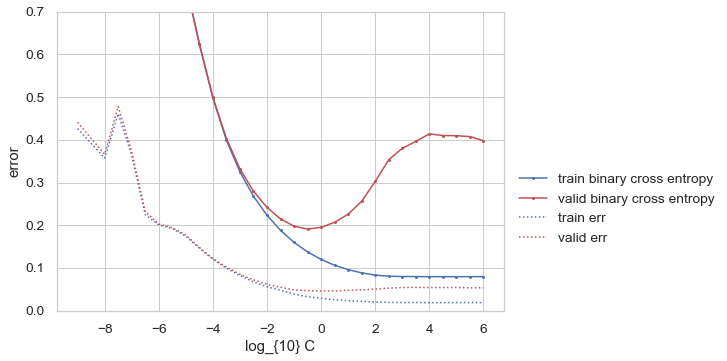

In [203]:
# Now I will create a new dataset with the convoluted images

#training
iter = 0
convoluted_training_x_tr2 = list()
for x in training_x_tr:
    print('training iter', iter)
    iter = iter + 1
    new_x = conv(x.reshape(28,28), l1_filter)
    flat_shape = new_x.shape[0]*new_x.shape[1]
    convoluted_training_x_tr2.append(new_x[:,:,1].reshape((flat_shape)))

#testing
iter = 0
convoluted_test_x_tr2 = list()
for x in test_x_tr:
    print('test iter', iter)
    iter = iter + 1
    new_x = conv(x.reshape(28,28), l1_filter)
    flat_shape = new_x.shape[0]*new_x.shape[1]
    convoluted_test_x_tr2.append(new_x[:,:,1].reshape((flat_shape)))

convoluted_training_x_tr2 = np.asarray(convoluted_training_x_tr2)
convoluted_test_x_tr2 = np.asarray(convoluted_test_x_tr2)

compute_results_model_on(convoluted_training_x_tr2, convoluted_test_x_tr2, 'edge detection convolution model 2')

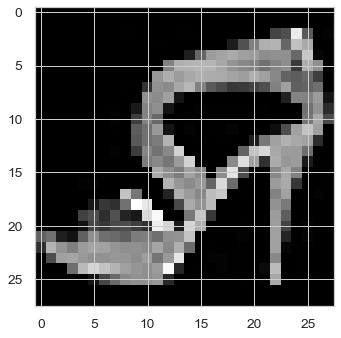

In [215]:
img_n = 150

plt.imshow(training_x_tr[img_n].reshape(28,28), interpolation='nearest', vmin=0, vmax=1, cmap='gray')


Filter  1
Filter  2
(26, 26)


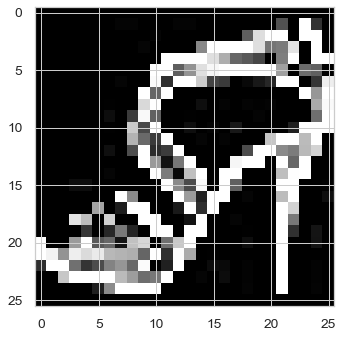

In [216]:
# different filters : https://www.saama.com/different-kinds-convolutional-filters/

l1_filter = np.zeros((2,3,3))

l1_filter[0, :, :] = np.array([[[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]]])
l1_filter[1, :, :] = np.array([[[0, -1, 0],
                                   [-1, 5, -1],
                                   [0, -1, 0]]])

new_image = conv(training_x_tr[img_n].reshape(28,28), l1_filter)
print(new_image[:,:,0].shape)
plt.imshow(new_image[:,:,0], interpolation='nearest', vmin=0, vmax=1, cmap='gray')